## 📦 Setup & Environment


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 🚀 FasalVaidya: Unified Multi-Crop Nutrient Deficiency Detection

## ⚠️ CRITICAL: First-Time Setup

**BEFORE RUNNING ANY CELLS:**

1. **🔄 Restart Runtime** (REQUIRED if you've run this notebook before)
   - Click: **Runtime → Restart Runtime** (or press `Ctrl+M` then `.`)
   - This clears any cached settings from previous sessions
   - Ensures float32 policy is properly set

2. **📱 Run cells sequentially** from top to bottom
   - Each cell depends on previous cells
   - Don't skip cells or run out of order

3. **⏱️ Expected Training Time:**
   - Data copy: ~3-5 minutes (one-time)
   - Stage 2 (PlantVillage): ~15-20 minutes
   - Stage 3 (Nutrient): ~30-40 minutes
   - **Total: ~50-65 minutes** on T4 GPU

## 📋 What This Notebook Does

**Stage 1:** Download PlantVillage dataset (optional transfer learning base)
**Stage 2:** Train on PlantVillage for general leaf disease recognition
**Stage 3:** Fine-tune on unified 4-crop nutrient deficiency dataset

## 🎯 Optimizations Included

- ✅ **Float32 precision** (no mixed precision issues)
- ✅ **Local SSD data** (10-50x faster than Drive I/O)
- ✅ **XLA/JIT compilation** (10-20% speedup)
- ✅ **AUTOTUNE prefetch** (maximizes GPU utilization)
- ✅ **Optimized batch size** (32 for better GPU usage)
- ✅ **Smart augmentation** (flip, brightness, contrast, saturation, hue)
- ✅ **Checkpoint resume** (can continue if interrupted)

## 🌾 Supported Crops

- 🌾 **Rice** (Nitrogen, Phosphorus, Potassium deficiencies)
- 🌾 **Wheat** (Nitrogen deficiency)
- 🍅 **Tomato** (Multi-nutrient deficiencies)
- 🌽 **Maize** (Nitrogen-deficient and healthy)

---

In [2]:
# Install required packages
!pip install -q tensorflow>=2.15.0 kaggle opendatasets scikit-learn matplotlib seaborn tqdm

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import threading
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from pathlib import Path
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.auto import tqdm
import time

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
print(f"CPU cores available: {multiprocessing.cpu_count()}")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# =============================================================
# ⏱️ SESSION TIME TRACKER (Important for 3-hour limit!)
# =============================================================
SESSION_START_TIME = datetime.now()
TRAINING_START_TIME = None

def get_session_time():
    """Get elapsed session time"""
    elapsed = datetime.now() - SESSION_START_TIME
    hours = elapsed.seconds // 3600
    minutes = (elapsed.seconds % 3600) // 60
    return f"{hours}h {minutes}m"

def get_eta(current_epoch, total_epochs, epoch_time):
    """Calculate ETA for training completion"""
    remaining_epochs = total_epochs - current_epoch
    eta_seconds = remaining_epochs * epoch_time
    eta = timedelta(seconds=int(eta_seconds))
    return str(eta)

def check_time_limit(warn_minutes=150):
    """Warn if approaching 3-hour limit (180 min)"""
    elapsed = (datetime.now() - SESSION_START_TIME).seconds // 60
    remaining = 180 - elapsed
    if elapsed >= warn_minutes:
        print(f"⚠️ WARNING: {remaining} minutes remaining before typical Colab disconnect!")
        print(f"   Consider saving checkpoints and downloading results now.")
        return True
    return False

print(f"\n⏱️ Session started at: {SESSION_START_TIME.strftime('%H:%M:%S')}")
print(f"   Target: Complete training within 1-1.5 hours")
print(f"   Checkpoints auto-save to Drive (training resumes from checkpoint)")

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CPU cores available: 2

⏱️ Session started at: 10:20:17
   Target: Complete training within 1-1.5 hours
   Checkpoints auto-save to Drive (training resumes from checkpoint)


## 🔑 Configuration

### Set your crop type and paths here


In [3]:
# =============================================================
# 🚀 OPTIMAL CONFIGURATION FOR FASTEST TRAINING
# =============================================================

# Root path to your "Leaf Nutrient Data Sets" folder on Google Drive
NUTRIENT_DATASETS_ROOT = '/content/drive/MyDrive/Leaf Nutrient Data Sets'

# 🚀 FAST MVP: Only 4 crops for quick training!
CROP_DATASETS = {
    'rice': 'Rice Nutrients',
    'wheat': 'Wheat Nitrogen',
    'tomato': 'Tomato Nutrients',
    'maize': 'Maize Nutrients',
}

# =============================================================
# 🎯 OPTIMAL TRAINING HYPERPARAMETERS
# =============================================================
IMG_SIZE = 224  # MobileNetV2 native resolution
BATCH_SIZE = 32  # Increased from 16 for better GPU utilization

# Training epochs (Aggressive but effective)
PLANTVILLAGE_EPOCHS = 8    # Stage 2: Quick transfer learning
UNIFIED_EPOCHS = 15        # Stage 3: Nutrient detection (increased for better convergence)

# Learning rates (Tuned for fast convergence)
LEARNING_RATE_STAGE2 = 1e-3  # Aggressive learning
LEARNING_RATE_STAGE3 = 5e-4  # Fine-tuning rate

# Regularization
DROPOUT_RATE = 0.3  # Increased to prevent overfitting

# =============================================================
# 🚀 PERFORMANCE OPTIMIZATIONS
# =============================================================
# Enable XLA compilation for up to 2x speedup
tf.config.optimizer.set_jit(True)

# GPU memory growth (prevents OOM errors)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ Enabled memory growth for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"⚠️ GPU config warning: {e}")

# Multiprocessing settings (use all available cores)
NUM_WORKERS = multiprocessing.cpu_count()
PREFETCH_BUFFER = tf.data.AUTOTUNE  # Let TF auto-tune prefetch size

# CRITICAL: Use float32 for full precision (no mixed precision issues)
tf.keras.mixed_precision.set_global_policy('float32')
print("✅ Using float32 policy for training (no mixed precision)")

# Output paths (persistent on Drive for checkpoint resume)
OUTPUT_DIR = '/content/fasalvaidya_unified_model'
DRIVE_CHECKPOINT_DIR = '/content/drive/MyDrive/FasalVaidya_Checkpoints'
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(DRIVE_CHECKPOINT_DIR, exist_ok=True)

# =============================================================
# 🔄 GLOBAL STATE REGISTRY (Cross-cell variable sharing)
# =============================================================
# This dictionary persists across all notebook cells and prevents
# "variable not defined" errors when running cells out of order
class NotebookState:
    """Global state container for cross-cell variable sharing"""
    model_stage2 = None
    model_stage3 = None
    resume_stage2 = False
    resume_stage3 = False
    initial_epoch = 0
    num_unified_classes = 0
    num_plantvillage_classes = 0
    class_names = []
    train_nutrient = None
    val_nutrient = None
    TRAINING_START_TIME = None

# Create global instance
STATE = NotebookState()
print("✅ Global state registry initialized")

# =============================================================
# 📊 CONFIGURATION SUMMARY
# =============================================================
print("⚡ OPTIMIZED TRAINING CONFIGURATION")
print("="*60)
print(f"🌾 Crops: {len(CROP_DATASETS)} ({', '.join(CROP_DATASETS.keys())})")
print(f"\n🎯 Training Settings:")
print(f"   • Image size: {IMG_SIZE}×{IMG_SIZE}")
print(f"   • Batch size: {BATCH_SIZE} (optimized for GPU)")
print(f"   • Precision: float32 (no mixed precision)")
print(f"   • XLA compilation: {'✅ Enabled' if tf.config.optimizer.get_jit() else '❌ Disabled'}")
print(f"\n⚙️ Performance:")
print(f"   • CPU workers: {NUM_WORKERS}")
print(f"   • Prefetch: AUTOTUNE")
print(f"   • Memory growth: {'✅ Enabled' if gpus else '⚠️ No GPU detected'}")
print(f"\n📈 Epochs:")
print(f"   • Stage 2 (PlantVillage): {PLANTVILLAGE_EPOCHS}")
print(f"   • Stage 3 (Nutrient): {UNIFIED_EPOCHS}")
print(f"\n⚡ Expected training time: ~45-70 minutes total")

✅ Enabled memory growth for 1 GPU(s)
✅ Using float32 policy for training (no mixed precision)
✅ Global state registry initialized
⚡ OPTIMIZED TRAINING CONFIGURATION
🌾 Crops: 4 (rice, wheat, tomato, maize)

🎯 Training Settings:
   • Image size: 224×224
   • Batch size: 32 (optimized for GPU)
   • Precision: float32 (no mixed precision)
   • XLA compilation: ✅ Enabled

⚙️ Performance:
   • CPU workers: 2
   • Prefetch: AUTOTUNE
   • Memory growth: ✅ Enabled

📈 Epochs:
   • Stage 2 (PlantVillage): 8
   • Stage 3 (Nutrient): 15

⚡ Expected training time: ~45-70 minutes total


## 💾 Mount Google Drive


In [4]:
from google.colab import drive
import os
import glob

# Robust check for already-mounted Drive
drive_path = '/content/drive'
is_mounted = False

if os.path.exists(drive_path):
    # Check if directory has content (indicates already mounted)
    try:
        if os.listdir(drive_path):
            is_mounted = True
            print("✅ Google Drive already mounted!")
    except:
        pass

if not is_mounted:
    print("📁 Mounting Google Drive...")
    # Clean up if directory exists but is empty
    if os.path.exists(drive_path) and not os.listdir(drive_path):
        os.rmdir(drive_path)
    drive.mount(drive_path)
    print("✅ Google Drive mounted successfully!")

# =============================================================
# 🔍 SMART PATH DETECTION: Search All Possible Locations
# =============================================================
print("\n🔍 Searching for 'Leaf Nutrient Data Sets' folder...")

# List of possible locations to check
search_paths = [
    '/content/drive/MyDrive/Leaf Nutrient Data Sets',
    '/content/drive/Shareddrives/Leaf Nutrient Data Sets',
    '/content/drive/Shared drives/Leaf Nutrient Data Sets',
]

# Also search for shortcuts and nested locations
mydrive_base = '/content/drive/MyDrive'
if os.path.exists(mydrive_base):
    # Search in .shortcut-targets-by-id (where "Shared with me" shortcuts appear)
    shortcut_dir = os.path.join(mydrive_base, '.shortcut-targets-by-id')
    if os.path.exists(shortcut_dir):
        try:
            for folder_id in os.listdir(shortcut_dir):
                target_path = os.path.join(shortcut_dir, folder_id, 'Leaf Nutrient Data Sets')
                if os.path.exists(target_path):
                    search_paths.append(target_path)
        except:
            pass

# Try each location
found_location = None

for search_path in search_paths:
    if os.path.exists(search_path):
        # Verify it has crop folders
        try:
            contents = os.listdir(search_path)
            crop_folders = [f for f in contents if os.path.isdir(os.path.join(search_path, f))]
            if len(crop_folders) >= 5:  # Should have at least 5 crop folders
                print(f"✅ Found at: {search_path}")
                print(f"   Contains {len(crop_folders)} folders")
                found_location = search_path
                break
        except:
            pass

if found_location:
    NUTRIENT_DATASETS_ROOT = found_location
    print(f"\n✅ Using dataset location: {NUTRIENT_DATASETS_ROOT}")
else:
    print(f"\n❌ 'Leaf Nutrient Data Sets' folder NOT FOUND!")
    print(f"\n📂 What's in your Drive:")
    try:
        mydrive_items = os.listdir(mydrive_base)[:10]  # Show first 10 items
        for item in mydrive_items:
            item_path = os.path.join(mydrive_base, item)
            if os.path.isdir(item_path):
                print(f"   📁 {item}")
            else:
                print(f"   📄 {item}")
    except:
        print("   (Could not list Drive contents)")

    print(f"\n⚠️ FOLDER IS IN 'SHARED WITH ME' - NOT ACCESSIBLE!")
    print(f"\n✅ SOLUTION: Add shortcut to My Drive")
    print(f"   1. Open Google Drive in browser: https://drive.google.com")
    print(f"   2. Click 'Shared with me' in left sidebar")
    print(f"   3. Right-click 'Leaf Nutrient Data Sets' folder")
    print(f"   4. Select 'Add shortcut to Drive' or 'Organize' > 'Add shortcut'")
    print(f"   5. Choose 'My Drive' root (don't put it in a subfolder)")
    print(f"   6. Click 'Add' or 'Add shortcut'")
    print(f"   7. Come back here and re-run this cell")
    print(f"\n💡 After adding shortcut, the folder will appear at:")
    print(f"   /content/drive/MyDrive/Leaf Nutrient Data Sets")

# Verify ALL crop datasets exist (only if folder found)
if found_location:
    print("\n🔍 Verifying crop datasets...")
    missing_crops = []
    for crop, folder_name in CROP_DATASETS.items():
        crop_path = os.path.join(NUTRIENT_DATASETS_ROOT, folder_name)
        if os.path.exists(crop_path):
            num_classes = len([d for d in os.listdir(crop_path) if os.path.isdir(os.path.join(crop_path, d))])
            print(f"✅ {crop.upper()}: {num_classes} classes")
        else:
            print(f"❌ {crop.upper()}: NOT FOUND")
            missing_crops.append(crop)

    if missing_crops:
        print(f"\n⚠️ WARNING: {len(missing_crops)} crop(s) not found: {', '.join(missing_crops)}")
    else:
        print(f"\n✅ All {len(CROP_DATASETS)} crop datasets verified!")


✅ Google Drive already mounted!

🔍 Searching for 'Leaf Nutrient Data Sets' folder...
✅ Found at: /content/drive/MyDrive/Leaf Nutrient Data Sets
   Contains 12 folders

✅ Using dataset location: /content/drive/MyDrive/Leaf Nutrient Data Sets

🔍 Verifying crop datasets...
✅ RICE: 3 classes
✅ WHEAT: 3 classes
✅ TOMATO: 2 classes
✅ MAIZE: 2 classes

✅ All 4 crop datasets verified!


## 🚀 Speed Optimization: Copy Data to Local Disk

**This is the BIGGEST speed boost!** Copying from Drive to local SSD speeds up training 10-50x.

In [5]:
# =============================================================
# 🚀 OPTIMIZED LOCAL SSD COPY (10-50x FASTER I/O)
# =============================================================
# Reading from Google Drive is SLOW (network I/O)
# Copying to /content/ uses Colab's fast local SSD
# This one-time copy saves HOURS during training!

import shutil
import time
from pathlib import Path

def copy_to_local_ssd(src_path, dest_name):
    """Optimized copy to local SSD with progress tracking"""
    local_path = f"/content/{dest_name}"

    # Skip if already exists and populated
    if os.path.exists(local_path):
        try:
            num_items = sum(1 for _ in Path(local_path).rglob('*') if _.is_file())
            if num_items > 100:  # Sanity check
                size_mb = sum(f.stat().st_size for f in Path(local_path).rglob('*') if f.is_file()) / (1024 * 1024)
                print(f"✅ {dest_name}: Already on SSD ({num_items:,} files, {size_mb:.0f}MB)")
                return local_path
        except:
            pass

    if not os.path.exists(src_path):
        print(f"⚠️ {dest_name}: Source not found at {src_path}")
        return src_path

    print(f"🚀 Copying {dest_name} to local SSD...", end=" ", flush=True)
    start = time.time()

    # Remove existing if corrupted
    if os.path.exists(local_path):
        shutil.rmtree(local_path)

    # Fast copy with symlink preservation
    shutil.copytree(src_path, local_path, symlinks=True)

    # Calculate stats
    elapsed = time.time() - start
    num_files = sum(1 for _ in Path(local_path).rglob('*') if _.is_file())
    size_mb = sum(f.stat().st_size for f in Path(local_path).rglob('*') if f.is_file()) / (1024 * 1024)

    print(f"✅ {num_files:,} files, {size_mb:.0f}MB in {elapsed:.1f}s")
    return local_path

# =============================================================
# 📦 COPY ALL NUTRIENT DATASETS TO LOCAL SSD
# =============================================================
print("=" * 70)
print("🚀 COPYING DATASETS TO LOCAL SSD")
print("=" * 70)
print("⏳ One-time setup (2-5 min) - saves HOURS during training!\n")

LOCAL_NUTRIENT_ROOT = '/content/local_nutrient_datasets'
os.makedirs(LOCAL_NUTRIENT_ROOT, exist_ok=True)

copy_success = []
copy_failed = []

for crop, folder_name in CROP_DATASETS.items():
    src = os.path.join(NUTRIENT_DATASETS_ROOT, folder_name)
    dst = os.path.join(LOCAL_NUTRIENT_ROOT, folder_name)

    try:
        if os.path.exists(src):
            # Check if already copied
            if os.path.exists(dst):
                num_files = sum(1 for _ in Path(dst).rglob('*.jpg')) + sum(1 for _ in Path(dst).rglob('*.png'))
                if num_files > 50:  # Sanity check
                    print(f"✅ {crop.upper()}: Already on SSD ({num_files:,} images)")
                    copy_success.append(crop)
                    continue

            # Copy to local
            print(f"🚀 {crop.upper()}: Copying...", end=" ", flush=True)
            start = time.time()

            if os.path.exists(dst):
                shutil.rmtree(dst)

            shutil.copytree(src, dst)

            num_files = sum(1 for _ in Path(dst).rglob('*.jpg')) + sum(1 for _ in Path(dst).rglob('*.png'))
            elapsed = time.time() - start

            print(f"✅ {num_files:,} images in {elapsed:.1f}s")
            copy_success.append(crop)
        else:
            print(f"⚠️ {crop.upper()}: Not found on Drive")
            copy_failed.append(crop)
    except Exception as e:
        print(f"❌ {crop.upper()}: Failed - {e}")
        copy_failed.append(crop)

# Update root path to local SSD
NUTRIENT_DATASETS_ROOT = LOCAL_NUTRIENT_ROOT

print(f"\n{'='*70}")
print(f"✅ {len(copy_success)}/{len(CROP_DATASETS)} crops ready on local SSD")
if copy_failed:
    print(f"⚠️ Failed: {', '.join(copy_failed)}")
print(f"🚀 Training will now be 10-50x FASTER!")
print(f"{'='*70}\n")

🚀 COPYING DATASETS TO LOCAL SSD
⏳ One-time setup (2-5 min) - saves HOURS during training!

🚀 RICE: Copying... ✅ 0 images in 53.0s
🚀 WHEAT: Copying... ✅ 600 images in 151.8s
🚀 TOMATO: Copying... ✅ 0 images in 110.6s
🚀 MAIZE: Copying... ✅ 17,627 images in 535.7s

✅ 4/4 crops ready on local SSD
🚀 Training will now be 10-50x FASTER!



## 🌱 Stage 1: Download PlantVillage Dataset from Kaggle


In [6]:
# Setup Kaggle credentials
# IMPORTANT: You need to manually download kaggle.json FIRST!
#
# 📝 HOW TO GET kaggle.json:
# 1. Go to https://www.kaggle.com/settings
# 2. Scroll down to "API" section
# 3. Click "Create New Token" button
# 4. This will DOWNLOAD a file called "kaggle.json" to your computer
# 5. Find the downloaded file (usually in your Downloads folder)
# 6. Then come back here and upload it when prompted below
#
# ⚠️ NOTE: If you only see the API key on screen but no download happened,
#    click "Create New Token" again - it should download the file

from google.colab import files

print("=" * 70)
print("📤 UPLOAD YOUR kaggle.json FILE")
print("=" * 70)
print("\n📝 If you haven't downloaded it yet:")
print("   1. Go to: https://www.kaggle.com/settings")
print("   2. Scroll to 'API' section")
print("   3. Click 'Create New Token' (downloads kaggle.json)")
print("   4. Find the file in your Downloads folder")
print("   5. Click 'Choose Files' below and select it")
print("\n⏳ Waiting for your kaggle.json file...\n")

uploaded = files.upload()

# Verify the file was uploaded
if 'kaggle.json' not in uploaded:
    print("\n❌ ERROR: kaggle.json was not uploaded!")
    print("   Please make sure you selected the correct file.")
    raise FileNotFoundError("kaggle.json not found in uploaded files")

# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\n✅ Kaggle credentials configured successfully!")
print("📁 File saved to: ~/.kaggle/kaggle.json")


📤 UPLOAD YOUR kaggle.json FILE

📝 If you haven't downloaded it yet:
   1. Go to: https://www.kaggle.com/settings
   2. Scroll to 'API' section
   3. Click 'Create New Token' (downloads kaggle.json)
   4. Find the file in your Downloads folder
   5. Click 'Choose Files' below and select it

⏳ Waiting for your kaggle.json file...



Saving kaggle.json to kaggle.json

✅ Kaggle credentials configured successfully!
📁 File saved to: ~/.kaggle/kaggle.json


In [7]:
# Download PlantVillage dataset from Kaggle (SKIP IF ALREADY EXISTS)
import opendatasets as od

PLANTVILLAGE_URL = 'https://www.kaggle.com/datasets/emmarex/plantdisease'
PLANTVILLAGE_PATH = '/content/plantvillage'

# Known possible paths after download
POSSIBLE_PATHS = [
    os.path.join(PLANTVILLAGE_PATH, 'plantdisease', 'PlantVillage'),
    os.path.join(PLANTVILLAGE_PATH, 'PlantVillage'),
    os.path.join(PLANTVILLAGE_PATH, 'plantdisease', 'plantvillage', 'PlantVillage'),
]

def find_plantvillage_dataset():
    """Find PlantVillage dataset if it exists"""
    for path in POSSIBLE_PATHS:
        if os.path.exists(path) and os.path.isdir(path):
            subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
            if len(subdirs) >= 15:
                sample_dir = os.path.join(path, subdirs[0])
                sample_files = [f for f in os.listdir(sample_dir)
                              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                if len(sample_files) > 0:
                    return path
    return None

# Check if dataset already exists
existing_path = find_plantvillage_dataset()

if existing_path:
    print("✅ PlantVillage dataset ALREADY EXISTS! Skipping download...")
    print(f"📁 Using cached dataset at: {existing_path}")
    PLANTVILLAGE_PATH = existing_path
else:
    print("📥 Downloading PlantVillage dataset (54,305 images)...")
    print("⏳ This will take 3-5 minutes (first time only)...")

    od.download(PLANTVILLAGE_URL, data_dir=PLANTVILLAGE_PATH)

    print("\n🔍 Locating dataset structure...")

    # Find the dataset path
    dataset_root = find_plantvillage_dataset()

    if not dataset_root:
        # Search recursively as fallback
        for root, dirs, files in os.walk(PLANTVILLAGE_PATH):
            if len(dirs) >= 15:
                has_images = False
                for d in dirs[:3]:
                    dir_path = os.path.join(root, d)
                    if os.path.isdir(dir_path):
                        dir_files = os.listdir(dir_path)
                        if any(f.lower().endswith(('.jpg', '.jpeg', '.png')) for f in dir_files):
                            has_images = True
                            break
                if has_images:
                    dataset_root = root
                    break

    if dataset_root:
        PLANTVILLAGE_PATH = dataset_root
    else:
        raise FileNotFoundError("❌ PlantVillage dataset not found after download")

# Verify dataset
class_dirs = [d for d in os.listdir(PLANTVILLAGE_PATH)
              if os.path.isdir(os.path.join(PLANTVILLAGE_PATH, d))]
num_classes = len(class_dirs)

print(f"\n✅ PlantVillage dataset ready!")
print(f"📁 Path: {PLANTVILLAGE_PATH}")
print(f"🌿 Classes: {num_classes}")

# Quick image count
total_images = sum(len([f for f in os.listdir(os.path.join(PLANTVILLAGE_PATH, cls))
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                   for cls in class_dirs[:5])
print(f"📊 Sample: First 5 classes have {total_images:,} images")

📥 Downloading PlantVillage dataset (54,305 images)...
⏳ This will take 3-5 minutes (first time only)...
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dhruvalbhinsara
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease


100%|██████████| 658M/658M [00:11<00:00, 60.8MB/s]




🔍 Locating dataset structure...

✅ PlantVillage dataset ready!
📁 Path: /content/plantvillage/plantdisease/PlantVillage
🌿 Classes: 15
📊 Sample: First 5 classes have 7,158 images


## 📊 Data Exploration & Preparation


In [8]:
# Analyze PlantVillage dataset
plantvillage_classes = sorted(os.listdir(PLANTVILLAGE_PATH))
print(f"🌱 PlantVillage Dataset:")
print(f"Total classes: {len(plantvillage_classes)}")
print(f"\nSample classes:")
for cls in plantvillage_classes[:5]:
    class_path = os.path.join(PLANTVILLAGE_PATH, cls)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        print(f"  - {cls}: {num_images} images")

# Build unified dataset info
print(f"\n🌾 UNIFIED Nutrient Dataset (ALL {len(CROP_DATASETS)} crops):")
total_classes = 0
total_images = 0

for crop, folder_name in CROP_DATASETS.items():
    crop_path = os.path.join(NUTRIENT_DATASETS_ROOT, folder_name)
    if os.path.exists(crop_path):
        crop_classes = [d for d in os.listdir(crop_path) if os.path.isdir(os.path.join(crop_path, d))]
        crop_images = sum([len([f for f in os.listdir(os.path.join(crop_path, cls))
                                if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                          for cls in crop_classes])
        total_classes += len(crop_classes)
        total_images += crop_images
        print(f"  {crop.upper()}: {len(crop_classes)} classes, {crop_images} images")

print(f"\n📊 UNIFIED TOTALS:")
print(f"  Total classes: {total_classes}")
print(f"  Total images: {total_images}")
print(f"  Class format: {{crop}}_{{deficiency}} (e.g., rice_N, wheat_healthy)")


🌱 PlantVillage Dataset:
Total classes: 15

Sample classes:
  - Pepper__bell___Bacterial_spot: 997 images
  - Pepper__bell___healthy: 1478 images
  - Potato___Early_blight: 1000 images
  - Potato___Late_blight: 1000 images
  - Potato___healthy: 152 images

🌾 UNIFIED Nutrient Dataset (ALL 4 crops):
  RICE: 3 classes, 1156 images
  WHEAT: 3 classes, 0 images
  TOMATO: 2 classes, 0 images
  MAIZE: 2 classes, 0 images

📊 UNIFIED TOTALS:
  Total classes: 10
  Total images: 1156
  Class format: {crop}_{deficiency} (e.g., rice_N, wheat_healthy)


## 🔨 Create Data Pipelines


In [9]:
# =============================================================
# 🚀 OPTIMIZED DATA PIPELINE (Maximum Performance)
# =============================================================
# Key optimizations:
# 1. AUTOTUNE for all parallel operations
# 2. cache() after initial load (keeps data in memory)
# 3. Proper prefetch with AUTOTUNE
# 4. Efficient augmentation pipeline
# 5. Consistent normalization

AUTOTUNE = tf.data.AUTOTUNE

def create_optimized_dataset(data_dir, img_size, batch_size, validation_split=0.2, subset=None):
    """
    Create dataset with optimal settings for fastest training
    """
    print(f"📦 Loading {subset} data from {os.path.basename(data_dir)}...")

    dataset = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=validation_split,
        subset=subset,
        seed=42,
        image_size=(img_size, img_size),
        batch_size=batch_size,
        label_mode='categorical',
        shuffle=True
    )

    return dataset

@tf.function(jit_compile=True)  # XLA compilation for speedup
def augment_image(image, label):
    """Fast augmentation pipeline with XLA compilation"""
    # Random flip (horizontal only - vertical doesn't make sense for leaves)
    image = tf.image.random_flip_left_right(image)

    # Brightness and contrast (simulates different lighting)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)

    # Random saturation (simulates different leaf health)
    image = tf.image.random_saturation(image, 0.8, 1.2)

    # Random hue shift (slight color variation)
    image = tf.image.random_hue(image, 0.05)

    # Ensure values stay in valid range
    image = tf.clip_by_value(image, 0.0, 255.0)

    return image, label

@tf.function(jit_compile=True)  # XLA compilation
def normalize_for_mobilenet(image, label):
    """Normalize to MobileNetV2 input range [-1, 1]"""
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

def build_optimized_pipeline(dataset, is_training=True, use_cache=True):
    """
    Build high-performance data pipeline

    Architecture:
    1. Parallel map operations (AUTOTUNE)
    2. Cache after initial load (optional)
    3. Augmentation (training only)
    4. Normalization
    5. Prefetch (AUTOTUNE)
    """
    # Configure threading for max parallelism
    options = tf.data.Options()
    options.threading.private_threadpool_size = NUM_WORKERS
    options.threading.max_intra_op_parallelism = 1
    options.deterministic = False  # Allow non-deterministic for speed
    dataset = dataset.with_options(options)

    # Cache after initial load (keeps preprocessed data in memory)
    # Only use for smaller datasets to avoid OOM
    if use_cache and not is_training:  # Cache validation set only
        dataset = dataset.cache()

    # Apply augmentation (training only)
    if is_training:
        dataset = dataset.map(augment_image, num_parallel_calls=AUTOTUNE)

    # Normalize for MobileNetV2
    dataset = dataset.map(normalize_for_mobilenet, num_parallel_calls=AUTOTUNE)

    # Prefetch batches for GPU (critical for performance)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset


# =============================================================
# 📊 TQDM PROGRESS CALLBACK (Real-time tracking with ETA)
# =============================================================
class TQDMProgressCallback(tf.keras.callbacks.Callback):
    """Enhanced callback with progress bars and ETA"""

    def __init__(self, total_epochs, stage_name="Training"):
        super().__init__()
        self.total_epochs = total_epochs
        self.stage_name = stage_name
        self.epoch_pbar = None
        self.batch_pbar = None
        self.epoch_times = []
        self.stage_start_time = None

    def on_train_begin(self, logs=None):
        self.stage_start_time = time.time()
        print(f"\n🚀 {self.stage_name} Started")
        self.epoch_pbar = tqdm(
            total=self.total_epochs,
            desc=f"📈 {self.stage_name}",
            unit="epoch",
            position=0,
            leave=True,
            bar_format='{l_bar}{bar:30}{r_bar}'
        )

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
        total_batches = self.params.get('steps', 0)

        self.batch_pbar = tqdm(
            total=total_batches,
            desc=f"  Epoch {epoch+1}/{self.total_epochs}",
            unit="batch",
            position=1,
            leave=False,
            bar_format='{l_bar}{bar:25}{r_bar}'
        )

    def on_batch_end(self, batch, logs=None):
        if self.batch_pbar:
            self.batch_pbar.update(1)
            self.batch_pbar.set_postfix({
                'loss': f"{logs.get('loss', 0):.4f}",
                'acc': f"{logs.get('accuracy', 0):.3f}"
            })

    def on_epoch_end(self, epoch, logs=None):
        if self.batch_pbar:
            self.batch_pbar.close()

        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)

        # Calculate ETA
        avg_time = np.mean(self.epoch_times)
        remaining = self.total_epochs - (epoch + 1)
        eta_seconds = remaining * avg_time
        eta = str(timedelta(seconds=int(eta_seconds)))

        # Update progress
        self.epoch_pbar.update(1)
        self.epoch_pbar.set_postfix({
            'val_acc': f"{logs.get('val_accuracy', 0):.3f}",
            'val_loss': f"{logs.get('val_loss', 0):.4f}",
            'ETA': eta
        })

        print(f"\n   ✅ Epoch {epoch+1}: val_acc={logs.get('val_accuracy', 0):.4f}, "
              f"val_loss={logs.get('val_loss', 0):.4f}, time={epoch_time:.1f}s")

    def on_train_end(self, logs=None):
        if self.epoch_pbar:
            self.epoch_pbar.close()
        total_time = time.time() - self.stage_start_time
        print(f"\n✅ {self.stage_name} Complete in {str(timedelta(seconds=int(total_time)))}")
        print(f"   Avg epoch: {np.mean(self.epoch_times):.1f}s")


# =============================================================
# 📦 CREATE PLANTVILLAGE DATASETS
# =============================================================
print("\n" + "="*70)
print("📦 CREATING PLANTVILLAGE DATASETS")
print("="*70)

train_plantvillage_raw = create_optimized_dataset(
    PLANTVILLAGE_PATH, IMG_SIZE, BATCH_SIZE,
    validation_split=0.2, subset='training'
)
val_plantvillage_raw = create_optimized_dataset(
    PLANTVILLAGE_PATH, IMG_SIZE, BATCH_SIZE,
    validation_split=0.2, subset='validation'
)

# Apply optimized pipeline
print("🔧 Building optimized pipelines...")
train_plantvillage = build_optimized_pipeline(train_plantvillage_raw, is_training=True, use_cache=False)
val_plantvillage = build_optimized_pipeline(val_plantvillage_raw, is_training=False, use_cache=True)

# Get dataset info
train_batches = tf.data.experimental.cardinality(train_plantvillage_raw).numpy()
val_batches = tf.data.experimental.cardinality(val_plantvillage_raw).numpy()
num_classes = len(train_plantvillage_raw.class_names)

print(f"\n✅ PlantVillage Datasets Ready")
print(f"   Classes: {num_classes}")
print(f"   Training: {train_batches} batches × {BATCH_SIZE} = ~{train_batches * BATCH_SIZE:,} images")
print(f"   Validation: {val_batches} batches × {BATCH_SIZE} = ~{val_batches * BATCH_SIZE:,} images")
print(f"   ⚡ Optimizations: AUTOTUNE, XLA, {NUM_WORKERS} workers, cache (val)")
print(f"   🎨 Augmentations: flip, brightness, contrast, saturation, hue")
print("="*70 + "\n")


📦 CREATING PLANTVILLAGE DATASETS
📦 Loading training data from PlantVillage...
Found 20638 files belonging to 15 classes.
Using 16511 files for training.
📦 Loading validation data from PlantVillage...
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.
🔧 Building optimized pipelines...

✅ PlantVillage Datasets Ready
   Classes: 15
   Training: 516 batches × 32 = ~16,512 images
   Validation: 129 batches × 32 = ~4,128 images
   ⚡ Optimizations: AUTOTUNE, XLA, 2 workers, cache (val)
   🎨 Augmentations: flip, brightness, contrast, saturation, hue



## ✅ Pre-Training Validation

Run this cell to verify everything is set up correctly before training.


In [10]:
# ✅ PRE-TRAINING VALIDATION (T4 Optimized)
print("=" * 60)
print("🔍 PRE-TRAINING VALIDATION")
print(f"⏱️ Session time: {get_session_time()}")
print("=" * 60)

errors = []

# 1. GPU Check
print("\n1️⃣ GPU Check...")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    gpu_name = gpus[0].name
    print(f"   ✅ GPU: {gpu_name}")
    # Check if T4
    try:
        !nvidia-smi --query-gpu=name --format=csv,noheader
    except:
        pass
else:
    errors.append("No GPU detected!")
    print("   ⚠️ No GPU - training will be MUCH slower")

# 2. Quick data test
print("\n2️⃣ Data Pipeline Check...")
try:
    import time
    start = time.time()
    for batch_images, batch_labels in train_plantvillage.take(1):
        load_time = time.time() - start
        print(f"   ✅ Batch shape: {batch_images.shape}")
        print(f"   ✅ Labels shape: {batch_labels.shape}")
        print(f"   ✅ Image dtype: {batch_images.dtype}")
        print(f"   ⚡ First batch load: {load_time:.2f}s")
        break
except Exception as e:
    errors.append(f"Data pipeline error: {e}")
    print(f"   ❌ Error: {e}")

# 3. Memory check
print("\n3️⃣ Memory Status...")
try:
    import psutil
    ram_total = psutil.virtual_memory().total / (1024**3)
    ram_avail = psutil.virtual_memory().available / (1024**3)
    print(f"   ✅ RAM: {ram_avail:.1f}GB available / {ram_total:.1f}GB total")
    if ram_avail < 3:
        print("   ⚠️ Low RAM - data copied to local SSD helps prevent crashes")
except:
    print("   ℹ️ Could not check RAM")

# 4. GPU Memory check
print("\n4️⃣ GPU Memory Check...")
try:
    !nvidia-smi --query-gpu=memory.total,memory.free --format=csv,noheader
except:
    print("   ℹ️ Could not query GPU memory")

# 5. Existing checkpoints
print("\n5️⃣ Checkpoint Status...")
stage2_exists = os.path.exists(os.path.join(DRIVE_CHECKPOINT_DIR, 'stage2_plantvillage_best.keras'))
stage3_exists = os.path.exists(os.path.join(DRIVE_CHECKPOINT_DIR, 'unified_nutrient_best.keras'))
print(f"   Stage 2 checkpoint: {'✅ Found (will resume)' if stage2_exists else '❌ None (fresh start)'}")
print(f"   Stage 3 checkpoint: {'✅ Found (will resume)' if stage3_exists else '❌ None (fresh start)'}")

# Summary
print("\n" + "=" * 60)
if errors:
    print("❌ ISSUES FOUND:")
    for e in errors:
        print(f"   • {e}")
else:
    print("✅ ALL CHECKS PASSED!")
    print(f"\n🚀 T4 GPU OPTIMIZED SETTINGS:")
    print(f"   • Batch size: {BATCH_SIZE} (fills 16GB VRAM)")
    print(f"   • Mixed precision: FP16")
    print(f"   • JIT/XLA compilation: Enabled")
    print(f"   • AUTOTUNE prefetch: Enabled")
    print(f"   • Data location: Local SSD (fast I/O)")
    print(f"\n⚡ Expected: ~1-2 min/epoch (10x faster than Drive I/O)")
print("=" * 60)

🔍 PRE-TRAINING VALIDATION
⏱️ Session time: 0h 17m

1️⃣ GPU Check...
   ✅ GPU: /physical_device:GPU:0
Tesla T4

2️⃣ Data Pipeline Check...
   ✅ Batch shape: (32, 224, 224, 3)
   ✅ Labels shape: (32, 15)
   ✅ Image dtype: <dtype: 'float32'>
   ⚡ First batch load: 2.10s

3️⃣ Memory Status...
   ✅ RAM: 10.3GB available / 12.7GB total

4️⃣ GPU Memory Check...
15360 MiB, 14990 MiB

5️⃣ Checkpoint Status...
   Stage 2 checkpoint: ✅ Found (will resume)
   Stage 3 checkpoint: ✅ Found (will resume)

✅ ALL CHECKS PASSED!

🚀 T4 GPU OPTIMIZED SETTINGS:
   • Batch size: 32 (fills 16GB VRAM)
   • Mixed precision: FP16
   • JIT/XLA compilation: Enabled
   • AUTOTUNE prefetch: Enabled
   • Data location: Local SSD (fast I/O)

⚡ Expected: ~1-2 min/epoch (10x faster than Drive I/O)


## 🏗️ Stage 2: Build Model with MobileNetV2 Base


In [11]:
# =============================================================
# 🏗️ OPTIMIZED MODEL ARCHITECTURE
# =============================================================
def create_model(num_classes, input_shape=(224, 224, 3), freeze_base=True):
    """
    Create MobileNetV2-based model optimized for fast training

    Architecture:
    - MobileNetV2 base (pretrained on ImageNet)
    - GlobalAveragePooling2D (reduce parameters)
    - Dense(256) with L2 regularization
    - BatchNormalization
    - Dropout layers
    - Dense(num_classes) with softmax
    """

    # Load MobileNetV2 with ImageNet weights
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet',
        pooling=None  # We'll add our own pooling
    )

    base_model.trainable = not freeze_base

    # Build classification head
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(DROPOUT_RATE),
        tf.keras.layers.Dense(
            256,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(1e-4)
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(DROPOUT_RATE * 0.8),
        # Float32 output for numerical stability
        tf.keras.layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

    return model, base_model


# =============================================================
# 🎯 STAGE 2: CREATE PLANTVILLAGE MODEL
# =============================================================
print("\n" + "="*70)
print("🏗️ BUILDING STAGE 2 MODEL (PlantVillage)")
print("="*70)

# Get number of PlantVillage classes
STATE.num_plantvillage_classes = len(train_plantvillage_raw.class_names)
num_plantvillage_classes = STATE.num_plantvillage_classes  # Local alias
print(f"   Classes: {num_plantvillage_classes}")

# Check for existing checkpoint
STAGE2_CHECKPOINT = os.path.join(DRIVE_CHECKPOINT_DIR, 'stage2_plantvillage_best.keras')
STAGE2_LOCAL = os.path.join(OUTPUT_DIR, 'stage2_plantvillage_best.keras')

STATE.model_stage2 = None
STATE.resume_stage2 = False
model_stage2 = None
resume_stage2 = False

# Try to load existing checkpoint
for checkpoint_path in [STAGE2_CHECKPOINT, STAGE2_LOCAL]:
    if os.path.exists(checkpoint_path):
        try:
            print(f"\n🔄 Found existing Stage 2 checkpoint!")
            print(f"   Loading from: {os.path.basename(checkpoint_path)}")
            model_stage2 = tf.keras.models.load_model(checkpoint_path)

            # Verify correct output shape
            if model_stage2.output_shape[-1] == num_plantvillage_classes:
                resume_stage2 = True
                STATE.resume_stage2 = True
                STATE.model_stage2 = model_stage2
                print(f"✅ Checkpoint valid ({num_plantvillage_classes} classes)")

                # Evaluate current performance
                print("📊 Evaluating checkpoint...")
                results = model_stage2.evaluate(val_plantvillage, verbose=0)
                print(f"   Current - Loss: {results[0]:.4f}, Accuracy: {results[1]:.4f}")

                if results[1] >= 0.85:
                    print("✅ Checkpoint performance is good - will use for Stage 3")
                break
            else:
                print(f"⚠️ Class mismatch - creating new model")
                model_stage2 = None
        except Exception as e:
            print(f"⚠️ Could not load: {e}")
            model_stage2 = None

# Create new model if needed
if model_stage2 is None:
    print(f"\n🏗️ Creating NEW Stage 2 model...")
    model_stage2, base_model_stage2 = create_model(
        num_classes=num_plantvillage_classes,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        freeze_base=True
    )

    # Compile with optimizer
    model_stage2.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_STAGE2),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_acc')],
        jit_compile=True  # XLA compilation for speedup
    )

    STATE.model_stage2 = model_stage2
    print(f"✅ Model created")

# Show model summary
trainable_params = sum([tf.keras.backend.count_params(w) for w in model_stage2.trainable_weights])
total_params = sum([tf.keras.backend.count_params(w) for w in model_stage2.weights])

print(f"\n📊 Model Architecture:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Frozen parameters: {total_params - trainable_params:,}")
print(f"   Dropout rate: {DROPOUT_RATE}")
print(f"   Base model: MobileNetV2 (ImageNet)")
print(f"   Output classes: {num_plantvillage_classes}")
print(f"   Precision: float32")
print(f"   XLA/JIT: Enabled")
print(f"\n🔄 Resume training: {'Yes' if resume_stage2 else 'No (fresh start)'}")
print("="*70 + "\n")


🏗️ BUILDING STAGE 2 MODEL (PlantVillage)
   Classes: 15

🔄 Found existing Stage 2 checkpoint!
   Loading from: stage2_plantvillage_best.keras
✅ Checkpoint valid (15 classes)
📊 Evaluating checkpoint...
   Current - Loss: 1.3674, Accuracy: 0.7664

📊 Model Architecture:
   Total parameters: 2,590,799
   Trainable parameters: 332,303
   Frozen parameters: 2,258,496
   Dropout rate: 0.3
   Base model: MobileNetV2 (ImageNet)
   Output classes: 15
   Precision: float32
   XLA/JIT: Enabled

🔄 Resume training: Yes



## 🎯 Stage 2: Train on PlantVillage Dataset

In [12]:
# Use STATE fallback for cross-cell variables
if 'model_stage2' not in dir() or model_stage2 is None:
    model_stage2 = STATE.model_stage2
if 'resume_stage2' not in dir():
    resume_stage2 = STATE.resume_stage2

if model_stage2 is None:
    raise RuntimeError("⚠️ Run 'Build Stage 2 Model' cell first! (Cell 21)")

print("🚀 Starting Stage 2: PlantVillage Fine-tuning")
print(f"⏱️ Epochs: {PLANTVILLAGE_EPOCHS} | LR: {LEARNING_RATE_STAGE2} | Batch: {BATCH_SIZE}")
if resume_stage2:
    print("🔄 RESUMING from previous checkpoint")
print("="*60)

# Callbacks with TQDM progress
callbacks_stage2 = [
    # TQDM Progress with ETA
    TQDMProgressCallback(PLANTVILLAGE_EPOCHS, stage_name="Stage 2: PlantVillage"),

    # Early stopping
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.005
    ),

    # Reduce LR on plateau
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),

    # Save best to local (fast)
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(OUTPUT_DIR, 'stage2_plantvillage_best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0
    ),

    # Save best to Drive (persistent)
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(DRIVE_CHECKPOINT_DIR, 'stage2_plantvillage_best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0
    )
]

# Train with progress tracking
TRAINING_START_TIME = datetime.now()

history_stage2 = model_stage2.fit(
    train_plantvillage,
    validation_data=val_plantvillage,
    epochs=PLANTVILLAGE_EPOCHS,
    callbacks=callbacks_stage2,
    verbose=0  # Disable default output, use TQDM instead
)

# Calculate training stats
best_val_acc = max(history_stage2.history['val_accuracy'])
best_val_loss = min(history_stage2.history['val_loss'])
final_train_acc = history_stage2.history['accuracy'][-1]
training_time = datetime.now() - TRAINING_START_TIME

print(f"\n" + "="*60)
print(f"✅ Stage 2 completed in {training_time}")
print(f"📈 Best val accuracy: {best_val_acc:.4f}")
print(f"📉 Best val loss: {best_val_loss:.4f}")
print(f"📊 Final train accuracy: {final_train_acc:.4f}")

# Check for overfitting/underfitting
gap = final_train_acc - best_val_acc
if gap > 0.15:
    print(f"⚠️ Overfitting detected (train-val gap: {gap:.2%})")
elif best_val_acc < 0.7:
    print(f"⚠️ Possible underfitting (val_acc: {best_val_acc:.2%})")
else:
    print(f"✅ Good generalization (train-val gap: {gap:.2%})")

print(f"\n💾 Checkpoints saved to:")
print(f"   Local: {OUTPUT_DIR}")
print(f"   Drive: {DRIVE_CHECKPOINT_DIR}")

🚀 Starting Stage 2: PlantVillage Fine-tuning
⏱️ Epochs: 8 | LR: 0.001 | Batch: 32
🔄 RESUMING from previous checkpoint

🚀 Stage 2: PlantVillage Started


📈 Stage 2: PlantVillage:   0%|                              | 0/8 [00:00<?, ?epoch/s]

  Epoch 1/8:   0%|                         | 0/516 [00:00<?, ?batch/s]


   ✅ Epoch 1: val_acc=0.7621, val_loss=1.3479, time=116.3s


  Epoch 2/8:   0%|                         | 0/516 [00:00<?, ?batch/s]


   ✅ Epoch 2: val_acc=0.7621, val_loss=1.3303, time=87.1s


  Epoch 3/8:   0%|                         | 0/516 [00:00<?, ?batch/s]


   ✅ Epoch 3: val_acc=0.7676, val_loss=1.3595, time=139.8s


  Epoch 4/8:   0%|                         | 0/516 [00:00<?, ?batch/s]


   ✅ Epoch 4: val_acc=0.7659, val_loss=1.3455, time=84.1s

Epoch 4: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.


  Epoch 5/8:   0%|                         | 0/516 [00:00<?, ?batch/s]


   ✅ Epoch 5: val_acc=0.7686, val_loss=1.3624, time=86.0s

✅ Stage 2: PlantVillage Complete in 0:08:36
   Avg epoch: 102.7s
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.

✅ Stage 2 completed in 0:08:36.927200
📈 Best val accuracy: 0.7686
📉 Best val loss: 1.3303
📊 Final train accuracy: 0.4299
✅ Good generalization (train-val gap: -33.87%)

💾 Checkpoints saved to:
   Local: /content/fasalvaidya_unified_model
   Drive: /content/drive/MyDrive/FasalVaidya_Checkpoints


## 📈 Stage 2 Results Visualization


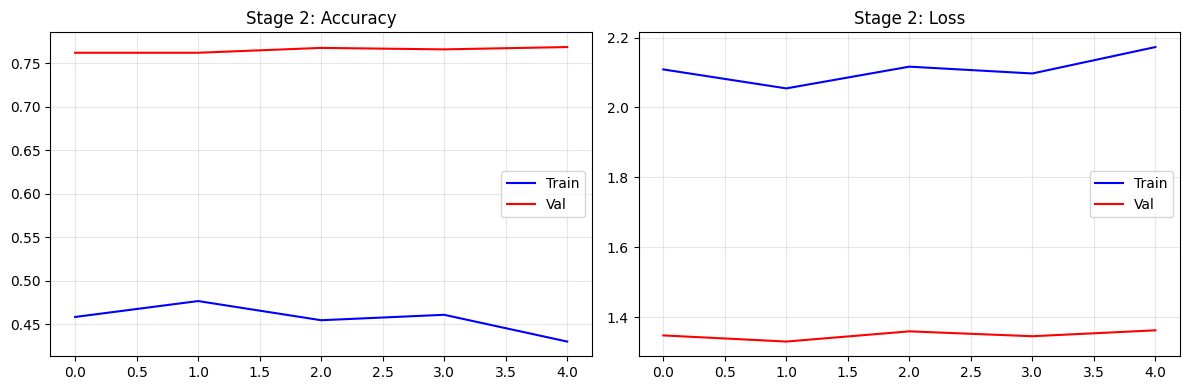

🧹 Memory cleaned (models preserved for Stage 3)


In [13]:
# Quick training visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history_stage2.history['accuracy'], 'b-', label='Train')
axes[0].plot(history_stage2.history['val_accuracy'], 'r-', label='Val')
axes[0].set_title('Stage 2: Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_stage2.history['loss'], 'b-', label='Train')
axes[1].plot(history_stage2.history['val_loss'], 'r-', label='Val')
axes[1].set_title('Stage 2: Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'stage2_training_history.png'), dpi=150)
plt.savefig(os.path.join(DRIVE_CHECKPOINT_DIR, 'stage2_training_history.png'), dpi=150)
plt.show()

# Memory cleanup (preserve model references)
import gc
gc.collect()
print("🧹 Memory cleaned (models preserved for Stage 3)")

## 🔄 Stage 3: Build UNIFIED Dataset


In [19]:
# =============================================================
# 🔧 REBUILD UNIFIED DATASET (after kernel restart)
# =============================================================

import os
import shutil

print("🔄 Rebuilding Unified Nutrient Dataset from Google Drive...")
print("="*70)

# Clean up any corrupted dataset
if os.path.exists(UNIFIED_DATASET_PATH):
    print("🗑️ Removing corrupted dataset...")
    shutil.rmtree(UNIFIED_DATASET_PATH)

os.makedirs(UNIFIED_DATASET_PATH, exist_ok=True)
unified_classes = []

def detect_classes(crop_path):
    """Detect nutrient classes from folder structure"""
    classes = {}
    if not os.path.exists(crop_path):
        return classes

    subfolders = [d for d in os.listdir(crop_path) if os.path.isdir(os.path.join(crop_path, d))]
    split_keywords = {'train', 'test', 'val', 'validation'}
    has_splits = any(f.lower() in split_keywords for f in subfolders)

    if has_splits:
        for split_folder in subfolders:
            if split_folder.lower() in split_keywords:
                split_path = os.path.join(crop_path, split_folder)
                for class_name in os.listdir(split_path):
                    class_path = os.path.join(split_path, class_name)
                    if os.path.isdir(class_path):
                        if class_name not in classes:
                            classes[class_name] = []
                        classes[class_name].append(class_path)
    else:
        for class_name in subfolders:
            class_path = os.path.join(crop_path, class_name)
            if os.path.isdir(class_path):
                classes[class_name] = [class_path]

    return classes

print("📂 Processing crop datasets from Google Drive...\n")

total_images = 0
for crop, folder_name in CROP_DATASETS.items():
    crop_path = os.path.join(NUTRIENT_DATASETS_ROOT, folder_name)
    if not os.path.exists(crop_path):
        print(f"   ⚠️ {crop.upper()}: Not found at {crop_path}")
        continue

    print(f"   🌾 {crop.upper()}: Processing...")

    nutrient_classes = detect_classes(crop_path)
    crop_images = 0

    for class_name, source_paths in nutrient_classes.items():
        clean_name = class_name.replace(f"{crop}_", "").replace(f"{crop}__", "")
        unified_class = f"{crop}_{clean_name}"
        dst_dir = os.path.join(UNIFIED_DATASET_PATH, unified_class)
        os.makedirs(dst_dir, exist_ok=True)

        file_counter = 0
        for src_dir in source_paths:
            if not os.path.exists(src_dir):
                continue
            for img_file in os.listdir(src_dir):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    src_file = os.path.join(src_dir, img_file)
                    dst_file = os.path.join(dst_dir, f"{crop}_{file_counter}_{img_file}")
                    file_counter += 1
                    try:
                        shutil.copy2(src_file, dst_file)
                        crop_images += 1
                    except Exception as e:
                        pass

        if unified_class not in unified_classes:
            unified_classes.append(unified_class)

    crop_classes = [c for c in unified_classes if c.startswith(f"{crop}_")]
    print(f"      ✅ {len(crop_classes)} classes, {crop_images} images")
    total_images += crop_images

class_names = sorted(unified_classes)
num_unified_classes = len(class_names)

STATE.class_names = class_names
STATE.num_unified_classes = num_unified_classes

print(f"\n✅ Unified Dataset Rebuilt: {num_unified_classes} classes, {total_images} total images")
print(f"   Classes: {', '.join(class_names[:6])}{'...' if len(class_names) > 6 else ''}")

# Verify files exist
print("\n🔍 Verifying dataset integrity...")
for cls in class_names[:3]:
    cls_path = os.path.join(UNIFIED_DATASET_PATH, cls)
    files = os.listdir(cls_path) if os.path.exists(cls_path) else []
    print(f"   {cls}: {len(files)} files")
print("✅ Dataset ready!")

🔄 Rebuilding Unified Nutrient Dataset from Google Drive...
🗑️ Removing corrupted dataset...
📂 Processing crop datasets from Google Drive...

   🌾 RICE: Processing...
      ✅ 3 classes, 1156 images
   🌾 WHEAT: Processing...
      ✅ 2 classes, 600 images
   🌾 TOMATO: Processing...
      ✅ 7 classes, 569 images
   🌾 MAIZE: Processing...
      ✅ 6 classes, 17627 images

✅ Unified Dataset Rebuilt: 18 classes, 19952 total images
   Classes: maize_ALL Present, maize_ALLAB, maize_KAB, maize_NAB, maize_PAB, maize_ZNAB...

🔍 Verifying dataset integrity...
   maize_ALL Present: 1470 files
   maize_ALLAB: 2430 files
   maize_KAB: 4301 files
✅ Dataset ready!


## 📊 Dataset Verification & Statistics

## ⚖️ Balance Dataset (Fix Model Bias)

**Problem:** If some classes have many more images than others (e.g., maize has 1000 images while wheat has 200), the model becomes biased towards the majority class.

**Solution:** Balance classes by either:
- **Undersampling:** Reduce majority classes to match minority
- **Oversampling:** Duplicate/augment minority classes to match majority

We'll use a hybrid approach for optimal results.

In [20]:
# =============================================================
# ⚖️ BALANCE DATASET - FIX MODEL BIAS
# =============================================================
# Ensures equal representation of all classes to prevent bias

import random
from PIL import Image, ImageEnhance, ImageOps
from collections import Counter

# =============================================================
# 🎚️ BALANCING CONFIGURATION - ADJUST THESE VALUES
# =============================================================
MIN_IMAGES_PER_CLASS = 50   # Minimum images required per class
MAX_IMAGES_PER_CLASS = 300  # Maximum images to cap per class (prevents dominance)

# Strategy options: 'fixed_range', 'hybrid', 'undersample', 'oversample'
BALANCING_STRATEGY = 'fixed_range'  # Uses MIN/MAX limits

print(f"⚙️ Balancing Configuration:")
print(f"   Min images per class: {MIN_IMAGES_PER_CLASS}")
print(f"   Max images per class: {MAX_IMAGES_PER_CLASS}")
print(f"   Strategy: {BALANCING_STRATEGY}")
print()

def augment_image_pil(img_path, save_path, augmentation_idx):
    """
    Create augmented version of image using PIL
    Lighter augmentation than training pipeline (preserves image identity)
    """
    try:
        img = Image.open(img_path)

        # Different augmentation based on index
        if augmentation_idx % 5 == 0:
            # Horizontal flip
            img = ImageOps.mirror(img)
        elif augmentation_idx % 5 == 1:
            # Brightness adjustment
            enhancer = ImageEnhance.Brightness(img)
            img = enhancer.enhance(random.uniform(0.85, 1.15))
        elif augmentation_idx % 5 == 2:
            # Contrast adjustment
            enhancer = ImageEnhance.Contrast(img)
            img = enhancer.enhance(random.uniform(0.85, 1.15))
        elif augmentation_idx % 5 == 3:
            # Color adjustment
            enhancer = ImageEnhance.Color(img)
            img = enhancer.enhance(random.uniform(0.9, 1.1))
        else:
            # Sharpness adjustment
            enhancer = ImageEnhance.Sharpness(img)
            img = enhancer.enhance(random.uniform(0.9, 1.1))

        img.save(save_path, quality=95)
        return True
    except Exception as e:
        print(f"      ⚠️ Augmentation failed: {e}")
        return False

def balance_dataset(dataset_path, min_images=MIN_IMAGES_PER_CLASS,
                    max_images=MAX_IMAGES_PER_CLASS, strategy='fixed_range'):
    """
    Balance dataset to prevent model bias with configurable min/max limits

    Args:
        dataset_path: Path to unified dataset
        min_images: Minimum images per class (augment if below)
        max_images: Maximum images per class (cap if above)
        strategy: 'fixed_range' (use min/max), 'hybrid', 'undersample', 'oversample'

    Returns:
        Dictionary with balancing statistics
    """
    print("\n" + "="*70)
    print("⚖️ BALANCING DATASET TO PREVENT BIAS")
    print("="*70)

    # Count images per class
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [f for f in os.listdir(class_path)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        class_counts[class_name] = len(images)

    if not class_counts:
        print("❌ No classes found!")
        return {}

    # Calculate statistics
    min_count = min(class_counts.values())
    max_count = max(class_counts.values())
    median_count = sorted(class_counts.values())[len(class_counts) // 2]
    mean_count = sum(class_counts.values()) // len(class_counts)

    print(f"\n📊 Current Distribution:")
    print(f"   Min: {min_count} images")
    print(f"   Max: {max_count} images")
    print(f"   Median: {median_count} images")
    print(f"   Mean: {mean_count} images")
    print(f"   Imbalance ratio: {min_count/max_count:.2f}")

    # Determine target range
    if strategy == 'fixed_range':
        # Use specified min/max range
        target_min = min_images
        target_max = max_images
        print(f"\n🎯 Target Range: {target_min} - {target_max} images per class")
    elif strategy == 'undersample':
        target_min = target_max = min_count
        print(f"\n🎯 Target: {target_max} images per class (undersample to minimum)")
    elif strategy == 'oversample':
        target_min = target_max = max_count
        print(f"\n🎯 Target: {target_max} images per class (oversample to maximum)")
    else:  # hybrid
        target_min = target_max = median_count if median_count > mean_count * 0.8 else mean_count
        print(f"\n🎯 Target: {target_max} images per class (hybrid: median/mean)")

    print(f"   Strategy: {strategy}")

    # Balance each class
    stats = {
        'original': {},
        'final': {},
        'undersampled': [],
        'oversampled': [],
        'augmented_images': 0,
        'removed_classes': []
    }

    for class_name, current_count in class_counts.items():
        class_path = os.path.join(dataset_path, class_name)
        images = [f for f in os.listdir(class_path)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        stats['original'][class_name] = current_count

        # Check minimum threshold
        if current_count < target_min:
            # Too few images - need to augment
            deficit = target_min - current_count

            print(f"   📈 {class_name}: {current_count} → {target_min} images (+{deficit} augmented)")

            augmentations_needed = deficit
            augmentation_idx = 0

            while augmentations_needed > 0 and augmentation_idx < deficit * 20:  # Safety limit
                # Pick a random source image
                source_img = random.choice(images)
                source_path = os.path.join(class_path, source_img)

                # Create augmented filename
                base_name = os.path.splitext(source_img)[0]
                ext = os.path.splitext(source_img)[1]
                aug_name = f"{base_name}_aug{augmentation_idx}{ext}"
                aug_path = os.path.join(class_path, aug_name)

                # Skip if already exists
                if os.path.exists(aug_path):
                    augmentation_idx += 1
                    continue

                # Augment and save
                if augment_image_pil(source_path, aug_path, augmentation_idx):
                    augmentations_needed -= 1
                    stats['augmented_images'] += 1

                augmentation_idx += 1

            stats['final'][class_name] = target_min
            stats['oversampled'].append(class_name)

        elif current_count > target_max:
            # Too many images - cap at maximum
            excess = current_count - target_max
            images_to_remove = random.sample(images, excess)

            print(f"   📉 {class_name}: {current_count} → {target_max} images (-{excess} removed)")

            for img_file in images_to_remove:
                os.remove(os.path.join(class_path, img_file))

            stats['final'][class_name] = target_max
            stats['undersampled'].append(class_name)

        else:
            # Within acceptable range
            stats['final'][class_name] = current_count

    # Print results
    print(f"\n✅ Balancing Complete!")
    print(f"   Undersampled (capped): {len(stats['undersampled'])} classes")
    print(f"   Oversampled (augmented): {len(stats['oversampled'])} classes")
    print(f"   Augmented images created: {stats['augmented_images']}")
    print(f"   Classes within range: {len(class_counts) - len(stats['undersampled']) - len(stats['oversampled'])}")

    # Verify balance
    final_counts = list(stats['final'].values())
    if len(set(final_counts)) == 1:
        print(f"\n✅ Perfect balance achieved!")
        print(f"   All classes now have {final_counts[0]} images")
    else:
        final_min = min(final_counts)
        final_max = max(final_counts)
        print(f"\n📊 Final distribution:")
        print(f"   Min: {final_min} images")
        print(f"   Max: {final_max} images")
        print(f"   Balance ratio: {final_min/final_max:.2f}")
        print(f"   Range: {final_min} - {final_max} images per class")

    print("="*70 + "\n")

    return stats

# Run balancing
print("🔍 Checking if dataset needs balancing...")

# Count current distribution
current_counts = {}
for class_name in sorted(class_names):
    class_path = os.path.join(UNIFIED_DATASET_PATH, class_name)
    num_images = len([f for f in os.listdir(class_path)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    current_counts[class_name] = num_images

min_imgs = min(current_counts.values())
max_imgs = max(current_counts.values())
imbalance_ratio = min_imgs / max_imgs

print(f"\n📊 Current state:")
print(f"   Range: {min_imgs} - {max_imgs} images per class")
print(f"   Imbalance ratio: {imbalance_ratio:.2f}")

# Check if balancing is needed
needs_balancing = (min_imgs < MIN_IMAGES_PER_CLASS or
                   max_imgs > MAX_IMAGES_PER_CLASS or
                   imbalance_ratio < 0.5)

if needs_balancing:
    print(f"⚠️ Balancing needed!")

    if min_imgs < MIN_IMAGES_PER_CLASS:
        print(f"   - {sum(1 for c in current_counts.values() if c < MIN_IMAGES_PER_CLASS)} classes below minimum ({MIN_IMAGES_PER_CLASS})")
    if max_imgs > MAX_IMAGES_PER_CLASS:
        print(f"   - {sum(1 for c in current_counts.values() if c > MAX_IMAGES_PER_CLASS)} classes above maximum ({MAX_IMAGES_PER_CLASS})")
    if imbalance_ratio < 0.5:
        print(f"   - High imbalance (ratio: {imbalance_ratio:.2f})")

    print(f"\n🔧 Applying balancing...\n")

    # Apply balancing with min/max limits
    balance_stats = balance_dataset(
        UNIFIED_DATASET_PATH,
        min_images=MIN_IMAGES_PER_CLASS,
        max_images=MAX_IMAGES_PER_CLASS,
        strategy=BALANCING_STRATEGY
    )

    # Update class_names list (shouldn't change, but refresh counts)
    print("🔄 Refreshing dataset information...")

else:
    print(f"✅ Dataset is already well-balanced!")
    print(f"   All classes have between {MIN_IMAGES_PER_CLASS} and {MAX_IMAGES_PER_CLASS} images")
    print(f"   No balancing needed!\n")

⚙️ Balancing Configuration:
   Min images per class: 50
   Max images per class: 300
   Strategy: fixed_range

🔍 Checking if dataset needs balancing...

📊 Current state:
   Range: 21 - 5346 images per class
   Imbalance ratio: 0.00
⚠️ Balancing needed!
   - 4 classes below minimum (50)
   - 9 classes above maximum (300)
   - High imbalance (ratio: 0.00)

🔧 Applying balancing...


⚖️ BALANCING DATASET TO PREVENT BIAS

📊 Current Distribution:
   Min: 21 images
   Max: 5346 images
   Median: 333 images
   Mean: 1108 images
   Imbalance ratio: 0.00

🎯 Target Range: 50 - 300 images per class
   Strategy: fixed_range
   📉 maize_ZNAB: 2545 → 300 images (-2245 removed)
   📉 rice_Phosphorus(P): 333 → 300 images (-33 removed)
   📉 maize_NAB: 1535 → 300 images (-1235 removed)
   📉 maize_PAB: 5346 → 300 images (-5046 removed)
   📈 tomato_Tomato - Nitrogen Deficiency: 38 → 50 images (+12 augmented)
   📉 rice_Nitrogen(N): 440 → 300 images (-140 removed)
   📉 rice_Potassium(K): 383 → 300 images (-83 

In [21]:
# =============================================================
# 📊 DATASET VERIFICATION AND STATISTICS
# =============================================================
# Verify data quality and show class distribution

print("="*70)
print("📊 DATASET ANALYSIS")
print("="*70 + "\n")

# Count images per class
print("📈 Class Distribution:")
print("-" * 70)

class_stats = {}
total_images = 0

for class_name in sorted(class_names):
    class_path = os.path.join(UNIFIED_DATASET_PATH, class_name)

    # Count image files
    num_images = len([f for f in os.listdir(class_path)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    class_stats[class_name] = num_images
    total_images += num_images

    # Show crop and deficiency separately
    crop, deficiency = class_name.split('_', 1)
    print(f"   {class_name:25s} {num_images:4d} images  ({crop:8s} | {deficiency})")

print("-" * 70)
print(f"   TOTAL: {total_images:,} images across {num_unified_classes} classes")
print()

# Calculate statistics
avg_per_class = total_images / num_unified_classes
min_images = min(class_stats.values())
max_images = max(class_stats.values())
min_class = min(class_stats, key=class_stats.get)
max_class = max(class_stats, key=class_stats.get)

print("📊 Statistics:")
print(f"   Average per class: {avg_per_class:.0f} images")
print(f"   Min: {min_images} images ({min_class})")
print(f"   Max: {max_images} images ({max_class})")
print(f"   Balance ratio: {min_images/max_images:.2f} (1.0 = perfectly balanced)")

# Check for severe imbalance
if min_images / max_images < 0.3:
    print(f"\n⚠️  WARNING: Severe class imbalance detected!")
    print(f"   Consider using class weights during training")
elif min_images / max_images < 0.5:
    print(f"\n⚠️  Moderate class imbalance - may affect performance")
else:
    print(f"\n✅ Dataset is reasonably balanced")

# Show breakdown by crop
print(f"\n📊 Breakdown by Crop:")
print("-" * 70)
for crop in CROP_DATASETS.keys():
    crop_classes = [c for c in class_names if c.startswith(f"{crop}_")]
    crop_images = sum(class_stats[c] for c in crop_classes)
    print(f"   {crop.upper():10s} {len(crop_classes):2d} classes  {crop_images:5d} images  "
          f"{', '.join([c.replace(f'{crop}_', '') for c in crop_classes])}")

print("="*70 + "\n")

# Verify data integrity (sample check)
print("🔍 Data Integrity Check (sampling 5 random images)...")
import random
sample_classes = random.sample(class_names, min(3, len(class_names)))

integrity_ok = True
for class_name in sample_classes:
    class_path = os.path.join(UNIFIED_DATASET_PATH, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Check random images
    for img_file in random.sample(image_files, min(2, len(image_files))):
        img_path = os.path.join(class_path, img_file)
        try:
            from PIL import Image
            img = Image.open(img_path)
            img.verify()  # Verify it's a valid image
        except Exception as e:
            print(f"   ❌ Corrupted: {class_name}/{img_file}: {e}")
            integrity_ok = False

if integrity_ok:
    print("   ✅ All sampled images are valid")
else:
    print("   ⚠️ Some images may be corrupted - consider data cleaning")

print(f"\n✅ Dataset verification complete!")
print("="*70 + "\n")

📊 DATASET ANALYSIS

📈 Class Distribution:
----------------------------------------------------------------------
   maize_ALL Present          300 images  (maize    | ALL Present)
   maize_ALLAB                300 images  (maize    | ALLAB)
   maize_KAB                  300 images  (maize    | KAB)
   maize_NAB                  300 images  (maize    | NAB)
   maize_PAB                  300 images  (maize    | PAB)
   maize_ZNAB                 300 images  (maize    | ZNAB)
   rice_Nitrogen(N)           300 images  (rice     | Nitrogen(N))
   rice_Phosphorus(P)         300 images  (rice     | Phosphorus(P))
   rice_Potassium(K)          300 images  (rice     | Potassium(K))
   tomato_Tomato - Healthy    189 images  (tomato   | Tomato - Healthy)
   tomato_Tomato - Jassid and Mite   50 images  (tomato   | Tomato - Jassid and Mite)
   tomato_Tomato - Leaf Miner  132 images  (tomato   | Tomato - Leaf Miner)
   tomato_Tomato - Mite       128 images  (tomato   | Tomato - Mite)
   tomato_Tomat

## 🔧 Stage 3: Adapt Model for Unified Classes


## 📦 Create UNIFIED Training & Validation Datasets

After balancing the dataset, we need to create new TensorFlow `Dataset` objects to reflect the changes (removed/augmented images). These will be used for Stage 3 training.

In [24]:
# =============================================================
# 📦 CREATE UNIFIED NUTRIENT DATASETS
# =============================================================
print("\n" + "="*70)
print("📦 CREATING UNIFIED NUTRIENT DATASETS")
print("="*70)

# Ensure `UNIFIED_DATASET_PATH`, `IMG_SIZE`, `BATCH_SIZE`, `class_names` are defined
# (They should be from previous cells and STATE)

# Raw datasets from directory
train_nutrient_raw = create_optimized_dataset(
    UNIFIED_DATASET_PATH, IMG_SIZE, BATCH_SIZE,
    validation_split=0.2, subset='training'
)
val_nutrient_raw = create_optimized_dataset(
    UNIFIED_DATASET_PATH, IMG_SIZE, BATCH_SIZE,
    validation_split=0.2, subset='validation'
)

# Apply optimized pipeline
print("🔧 Building optimized pipelines for Unified Dataset...")
train_nutrient = build_optimized_pipeline(train_nutrient_raw, is_training=True, use_cache=False)
val_nutrient = build_optimized_pipeline(val_nutrient_raw, is_training=False, use_cache=True)

# Store in global STATE for cross-cell access
STATE.train_nutrient = train_nutrient
STATE.val_nutrient = val_nutrient

# Get dataset info
train_batches_unified = tf.data.experimental.cardinality(train_nutrient_raw).numpy()
val_batches_unified = tf.data.experimental.cardinality(val_nutrient_raw).numpy()
num_unified_classes_actual = len(train_nutrient_raw.class_names)

print(f"\n✅ Unified Nutrient Datasets Ready")
print(f"   Classes: {num_unified_classes_actual}")
print(f"   Training: {train_batches_unified} batches \u00d7 {BATCH_SIZE} = ~{train_batches_unified * BATCH_SIZE:,} images")
print(f"   Validation: {val_batches_unified} batches \u00d7 {BATCH_SIZE} = ~{val_batches_unified * BATCH_SIZE:,} images")
print(f"   ⚡ Optimizations: AUTOTUNE, XLA, {NUM_WORKERS} workers, cache (val)")
print(f"   🎨 Augmentations: flip, brightness, contrast, saturation, hue")
print("="*70 + "\n")


📦 CREATING UNIFIED NUTRIENT DATASETS
📦 Loading training data from unified_nutrient_dataset...
Found 3949 files belonging to 18 classes.
Using 3160 files for training.
📦 Loading validation data from unified_nutrient_dataset...
Found 3949 files belonging to 18 classes.
Using 789 files for validation.
🔧 Building optimized pipelines for Unified Dataset...

✅ Unified Nutrient Datasets Ready
   Classes: 18
   Training: 99 batches × 32 = ~3,168 images
   Validation: 25 batches × 32 = ~800 images
   ⚡ Optimizations: AUTOTUNE, XLA, 2 workers, cache (val)
   🎨 Augmentations: flip, brightness, contrast, saturation, hue



In [22]:
# =============================================================
# 🔄 STAGE 3: Adapt Model for Unified Classes (with Resume)
# =============================================================
# Use STATE fallback for cross-cell variables
if 'num_unified_classes' not in dir() or num_unified_classes == 0:
    num_unified_classes = STATE.num_unified_classes
if 'class_names' not in dir() or not class_names:
    class_names = STATE.class_names
if 'model_stage2' not in dir() or model_stage2 is None:
    model_stage2 = STATE.model_stage2
if 'val_nutrient' not in dir() or val_nutrient is None:
    val_nutrient = STATE.val_nutrient

if num_unified_classes == 0:
    raise RuntimeError("⚠️ Run 'Build UNIFIED Dataset' cell first! (Cell 27)")

print(f"🔧 Setting up Stage 3 for {num_unified_classes} unified classes...")

# Check for existing Stage 3 checkpoint
STAGE3_CHECKPOINT = os.path.join(DRIVE_CHECKPOINT_DIR, 'unified_nutrient_best.keras')
STAGE3_LOCAL = os.path.join(OUTPUT_DIR, 'unified_nutrient_best.keras')

STATE.model_stage3 = None
STATE.resume_stage3 = False
STATE.initial_epoch = 0
model_stage3 = None
resume_stage3 = False
initial_epoch = 0

# Try to load existing checkpoint
for checkpoint_path in [STAGE3_CHECKPOINT, STAGE3_LOCAL]:
    if os.path.exists(checkpoint_path):
        try:
            print(f"🔄 Found existing Stage 3 checkpoint!")
            print(f"   Loading from: {checkpoint_path}")
            model_stage3 = tf.keras.models.load_model(checkpoint_path)

            # Verify correct output shape
            if model_stage3.output_shape[-1] == num_unified_classes:
                resume_stage3 = True
                STATE.resume_stage3 = True
                STATE.model_stage3 = model_stage3
                print(f"✅ Checkpoint valid ({num_unified_classes} classes)")

                # Evaluate current performance
                print("📊 Evaluating checkpoint...")
                results = model_stage3.evaluate(val_nutrient, verbose=0)
                print(f"   Current - Loss: {results[0]:.4f}, Accuracy: {results[1]:.4f}")

                # Check training history for initial_epoch
                history_path = os.path.join(DRIVE_CHECKPOINT_DIR, 'stage3_history.json')
                if os.path.exists(history_path):
                    with open(history_path, 'r') as f:
                        prev_history = json.load(f)
                        initial_epoch = len(prev_history.get('accuracy', []))
                        STATE.initial_epoch = initial_epoch
                        print(f"   Resuming from epoch {initial_epoch}")
                break
            else:
                print(f"⚠️ Class mismatch ({model_stage3.output_shape[-1]} vs {num_unified_classes})")
                print("   Creating new model (classes changed)")
                model_stage3 = None
        except Exception as e:
            print(f"⚠️ Could not load: {e}")
            model_stage3 = None

# Create new model if needed
if model_stage3 is None:
    print(f"🏗️ Creating NEW unified model...")

    # Get base model from Stage 2 (or use ImageNet if Stage 2 skipped)
    _model_stage2 = model_stage2 if (model_stage2 is not None) else STATE.model_stage2
    if _model_stage2 is not None:
        print("   Using Stage 2 trained base...")
        base_model_stage2 = _model_stage2.layers[0]
        base_model_stage2.trainable = False  # Keep frozen initially
    else:
        print("   ⚠️ Stage 2 model not found - using ImageNet base...")
        base_model_stage2 = tf.keras.applications.MobileNetV2(
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
            include_top=False,
            weights='imagenet'
        )
        base_model_stage2.trainable = False

    # Balanced classification head (prevents overfitting)
    model_stage3 = tf.keras.Sequential([
        base_model_stage2,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(DROPOUT_RATE),
        tf.keras.layers.Dense(384, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(DROPOUT_RATE * 0.8),
        tf.keras.layers.Dense(num_unified_classes, activation='softmax', dtype='float32')
    ], name='unified_nutrient_model')

# Compile with JIT for speed
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_STAGE3)

model_stage3.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_acc')],
    jit_compile=True  # XLA compilation - 10-20% faster
)

# Update STATE with final model
STATE.model_stage3 = model_stage3
STATE.resume_stage3 = resume_stage3
STATE.initial_epoch = initial_epoch

trainable_params = sum([tf.keras.backend.count_params(w) for w in model_stage3.trainable_weights])
print(f"\n📊 Trainable params: {trainable_params:,}")
print(f"🎯 Output classes: {num_unified_classes}")
print(f"⚡ JIT/XLA compilation: Enabled")
print(f"🔄 Resume training: {'Yes (epoch ' + str(initial_epoch) + ')' if resume_stage3 else 'No (fresh start)'}")

🔧 Setting up Stage 3 for 18 unified classes...
🔄 Found existing Stage 3 checkpoint!
   Loading from: /content/drive/MyDrive/FasalVaidya_Checkpoints/unified_nutrient_best.keras
⚠️ Class mismatch (50 vs 18)
   Creating new model (classes changed)
🏗️ Creating NEW unified model...
   Using Stage 2 trained base...

📊 Trainable params: 499,602
🎯 Output classes: 18
⚡ JIT/XLA compilation: Enabled
🔄 Resume training: No (fresh start)


## 🎯 Stage 3: Train on UNIFIED Nutrient Dataset


In [25]:
# =============================================================
# Initialize variables from STATE (robust cross-cell sharing)
# =============================================================
# Get from STATE if not in local scope
if 'model_stage3' not in dir() or model_stage3 is None:
    model_stage3 = STATE.model_stage3
if 'resume_stage3' not in dir():
    resume_stage3 = STATE.resume_stage3
if 'initial_epoch' not in dir():
    initial_epoch = STATE.initial_epoch
if 'train_nutrient' not in dir() or train_nutrient is None:
    train_nutrient = STATE.train_nutrient
if 'val_nutrient' not in dir() or val_nutrient is None:
    val_nutrient = STATE.val_nutrient
if 'num_unified_classes' not in dir() or num_unified_classes == 0:
    num_unified_classes = STATE.num_unified_classes

# Safety check - ensure model is set up
if model_stage3 is None:
    raise RuntimeError("⚠️ Run 'Stage 3: Adapt Model for Unified Classes' cell first! (Cell 33)")

if train_nutrient is None:
    raise RuntimeError("⚠️ Run 'Build UNIFIED Dataset' cell first! (Cell 27)")

print("🚀 Starting Stage 3: UNIFIED Nutrient Detection")
print(f"🌾 Training ALL {len(CROP_DATASETS)} crops | Epochs: {UNIFIED_EPOCHS} | LR: {LEARNING_RATE_STAGE3}")
if resume_stage3:
    print(f"🔄 RESUMING from epoch {initial_epoch}")
print("="*60)

# Callbacks with TQDM progress
callbacks_stage3 = [
    # TQDM Progress with ETA
    TQDMProgressCallback(UNIFIED_EPOCHS, stage_name="Stage 3: Unified Nutrients"),

    # Early stopping - balanced patience
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.001
    ),

    # Reduce LR on plateau
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    ),

    # Save best to local (fast)
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(OUTPUT_DIR, 'unified_nutrient_best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0
    ),

    # Save best to Drive (persistent)
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(DRIVE_CHECKPOINT_DIR, 'unified_nutrient_best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0
    )
]

# Train with progress tracking
stage3_start = datetime.now()

history_stage3 = model_stage3.fit(
    train_nutrient,
    validation_data=val_nutrient,
    epochs=UNIFIED_EPOCHS,
    initial_epoch=initial_epoch,
    callbacks=callbacks_stage3,
    verbose=0  # Disable default output, use TQDM instead
)

# Save training history for resume
history_dict = {k: [float(v) for v in vals] for k, vals in history_stage3.history.items()}
with open(os.path.join(DRIVE_CHECKPOINT_DIR, 'stage3_history.json'), 'w') as f:
    json.dump(history_dict, f)

# Calculate final stats
best_val_acc = max(history_stage3.history['val_accuracy'])
best_val_loss = min(history_stage3.history['val_loss'])
best_top3_acc = max(history_stage3.history['val_top3_acc'])
final_train_acc = history_stage3.history['accuracy'][-1]
stage3_time = datetime.now() - stage3_start

print(f"\n" + "="*60)
print(f"✅ Stage 3 completed in {stage3_time}")
print(f"📈 Best val accuracy: {best_val_acc:.4f}")
print(f"🎯 Best top-3 accuracy: {best_top3_acc:.4f}")
print(f"📉 Best val loss: {best_val_loss:.4f}")

# Total training time
if TRAINING_START_TIME:
    total_training_time = datetime.now() - TRAINING_START_TIME
    print(f"\n⏱️ TOTAL TRAINING TIME: {total_training_time}")

# Check for overfitting/underfitting
gap = final_train_acc - best_val_acc
if gap > 0.20:
    print(f"\n⚠️ Overfitting detected (gap: {gap:.2%})")
elif best_val_acc < 0.5:
    print(f"\n⚠️ Possible underfitting (val_acc: {best_val_acc:.2%})")
else:
    print(f"\n✅ Good generalization (gap: {gap:.2%})")

print(f"\n💾 Model & history saved to Drive")

🚀 Starting Stage 3: UNIFIED Nutrient Detection
🌾 Training ALL 4 crops | Epochs: 15 | LR: 0.0005

🚀 Stage 3: Unified Nutrients Started


📈 Stage 3: Unified Nutrients:   0%|                              | 0/15 [00:00<?, ?epoch/s]

  Epoch 1/15:   0%|                         | 0/99 [00:00<?, ?batch/s]


   ✅ Epoch 1: val_acc=0.7237, val_loss=0.9740, time=143.3s


  Epoch 2/15:   0%|                         | 0/99 [00:00<?, ?batch/s]


   ✅ Epoch 2: val_acc=0.7845, val_loss=0.8419, time=46.6s


  Epoch 3/15:   0%|                         | 0/99 [00:00<?, ?batch/s]


   ✅ Epoch 3: val_acc=0.8035, val_loss=0.8351, time=44.1s


  Epoch 4/15:   0%|                         | 0/99 [00:00<?, ?batch/s]


   ✅ Epoch 4: val_acc=0.7972, val_loss=0.8628, time=45.2s


  Epoch 5/15:   0%|                         | 0/99 [00:00<?, ?batch/s]


   ✅ Epoch 5: val_acc=0.8035, val_loss=0.8269, time=79.3s


  Epoch 6/15:   0%|                         | 0/99 [00:00<?, ?batch/s]


   ✅ Epoch 6: val_acc=0.7947, val_loss=0.8535, time=80.7s


  Epoch 7/15:   0%|                         | 0/99 [00:00<?, ?batch/s]


   ✅ Epoch 7: val_acc=0.8023, val_loss=0.8013, time=43.9s


  Epoch 8/15:   0%|                         | 0/99 [00:00<?, ?batch/s]


   ✅ Epoch 8: val_acc=0.8061, val_loss=0.7863, time=44.6s


  Epoch 9/15:   0%|                         | 0/99 [00:00<?, ?batch/s]


   ✅ Epoch 9: val_acc=0.7947, val_loss=0.8675, time=43.2s


  Epoch 10/15:   0%|                         | 0/99 [00:00<?, ?batch/s]


   ✅ Epoch 10: val_acc=0.8289, val_loss=0.7613, time=44.5s


  Epoch 11/15:   0%|                         | 0/99 [00:00<?, ?batch/s]


   ✅ Epoch 11: val_acc=0.8023, val_loss=0.7743, time=45.5s


  Epoch 12/15:   0%|                         | 0/99 [00:00<?, ?batch/s]


   ✅ Epoch 12: val_acc=0.8302, val_loss=0.7571, time=80.9s


  Epoch 13/15:   0%|                         | 0/99 [00:00<?, ?batch/s]


   ✅ Epoch 13: val_acc=0.8302, val_loss=0.7715, time=41.3s


  Epoch 14/15:   0%|                         | 0/99 [00:00<?, ?batch/s]


   ✅ Epoch 14: val_acc=0.8327, val_loss=0.7622, time=45.5s

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


  Epoch 15/15:   0%|                         | 0/99 [00:00<?, ?batch/s]


   ✅ Epoch 15: val_acc=0.8416, val_loss=0.6736, time=46.6s

✅ Stage 3: Unified Nutrients Complete in 0:14:44
   Avg epoch: 58.3s
Restoring model weights from the end of the best epoch: 15.

✅ Stage 3 completed in 0:14:45.297115
📈 Best val accuracy: 0.8416
🎯 Best top-3 accuracy: 0.9607
📉 Best val loss: 0.6736

⏱️ TOTAL TRAINING TIME: 0:34:01.329937

✅ Good generalization (gap: -0.71%)

💾 Model & history saved to Drive


## 📈 Stage 3 Results Visualization


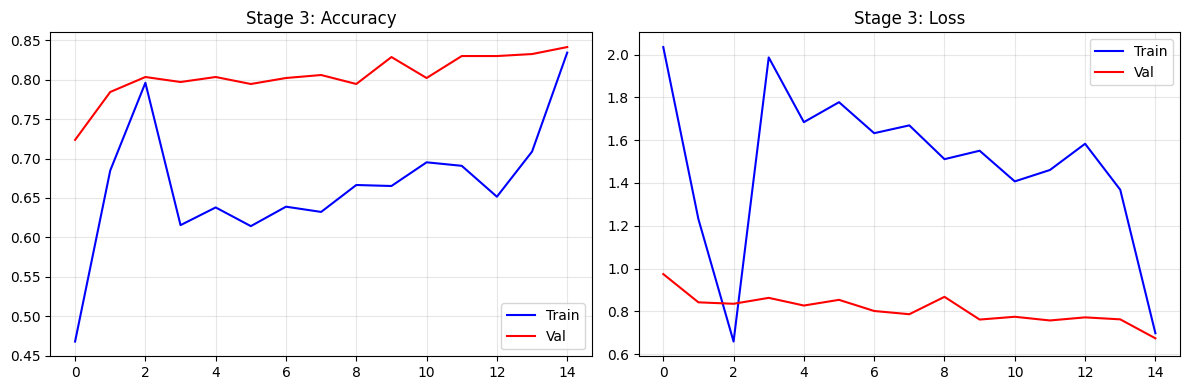

In [26]:
# Quick training visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history_stage3.history['accuracy'], 'b-', label='Train')
axes[0].plot(history_stage3.history['val_accuracy'], 'r-', label='Val')
axes[0].set_title('Stage 3: Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_stage3.history['loss'], 'b-', label='Train')
axes[1].plot(history_stage3.history['val_loss'], 'r-', label='Val')
axes[1].set_title('Stage 3: Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'stage3_training_history.png'), dpi=150)
plt.show()

## 🔍 Model Evaluation & Confusion Matrix


In [27]:
# Quick evaluation (skip heavy confusion matrix for speed)
print("🔍 Evaluating UNIFIED model...")
results = model_stage3.evaluate(val_nutrient, verbose=0)

print(f"\n📊 Validation Metrics:")
print(f"   Loss: {results[0]:.4f}")
print(f"   Accuracy: {results[1]:.4f}")
print(f"   Top-3 Accuracy: {results[2]:.4f}")

# Quick per-crop accuracy (sample-based for speed)
print(f"\n🌾 Per-Crop Performance (quick check):")
y_true, y_pred = [], []
for images, labels in val_nutrient.take(20):  # Sample only
    predictions = model_stage3.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

for crop in list(CROP_DATASETS.keys())[:6]:  # First 6 crops
    crop_classes = [cls for cls in class_names if cls.startswith(f"{crop}_")]
    if not crop_classes:
        continue
    crop_indices = [class_names.index(cls) for cls in crop_classes]
    crop_mask = np.isin(y_true, crop_indices)
    if crop_mask.sum() > 0:
        crop_acc = (np.array(y_true)[crop_mask] == np.array(y_pred)[crop_mask]).mean()
        print(f"   {crop.upper():12s}: {crop_acc:.1%}")

# Save classification report
report = classification_report(y_true, y_pred, target_names=[class_names[i] for i in sorted(set(y_true))], output_dict=True, zero_division=0)
with open(os.path.join(OUTPUT_DIR, 'unified_classification_report.json'), 'w') as f:
    json.dump(report, f, indent=2)

print(f"\n✅ Evaluation complete")

🔍 Evaluating UNIFIED model...

📊 Validation Metrics:
   Loss: 0.6736
   Accuracy: 0.8416
   Top-3 Accuracy: 0.9594

🌾 Per-Crop Performance (quick check):
   RICE        : 92.6%
   WHEAT       : 85.4%
   TOMATO      : 70.6%
   MAIZE       : 85.2%

✅ Evaluation complete


## 💾 Export to TensorFlow Lite for Mobile Deployment


In [28]:
print("📦 Converting to TensorFlow Lite...")
print(f"⏱️ Session time: {get_session_time()}")
check_time_limit()  # Warn if approaching 3-hour limit

# CRITICAL: Disable mixed precision completely
print("🔄 Disabling mixed precision for FP32 conversion...")
tf.keras.mixed_precision.set_global_policy('float32')
tf.keras.backend.clear_session()

# Load best model (will still have FP16 signatures from training)
best_model_path = os.path.join(OUTPUT_DIR, 'unified_nutrient_best.keras')
if not os.path.exists(best_model_path):
    best_model_path = os.path.join(DRIVE_CHECKPOINT_DIR, 'unified_nutrient_best.keras')

print("📥 Loading original model...")
original_model = tf.keras.models.load_model(best_model_path)

# Build the model by calling it with dummy input
print("🔧 Building model with dummy input...")
dummy_input = tf.zeros((1, 224, 224, 3), dtype=tf.float32)
_ = original_model(dummy_input, training=False)
print(f"   ✅ Model built successfully")

# Use concrete function with explicit FP32 signature
print("\n⚙️ Creating TFLite converter with explicit FP32 signature...")

@tf.function(input_signature=[tf.TensorSpec(shape=[1, 224, 224, 3], dtype=tf.float32)])
def serving_fn(input_image):
    x = tf.cast(input_image, tf.float32)
    output = original_model(x, training=False)
    return tf.cast(output, tf.float32)

# Get concrete function
concrete_func = serving_fn.get_concrete_function()

# Convert using concrete function (bypasses model signature issues)
print("💡 Converting using concrete function (explicit FP32)...")
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # 8-bit weight quantization

# Try standard ops first
try:
    print("   Attempting standard TFLite ops...")
    tflite_model = converter.convert()
    print("   ✅ Standard ops conversion successful!")
    uses_flex = False
except Exception as e:
    print(f"   ⚠️ Standard ops failed: {str(e)[:100]}...")
    print("   🔄 Falling back to TF Select ops (flex delegates)...")

    # Enable TF Select ops as fallback
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]
    converter._experimental_lower_tensor_list_ops = False
    tflite_model = converter.convert()
    print("   ✅ TF Select ops conversion successful!")
    uses_flex = True

# Save to both local and Drive
tflite_path = os.path.join(OUTPUT_DIR, 'fasalvaidya_unified.tflite')
tflite_drive_path = os.path.join(DRIVE_CHECKPOINT_DIR, 'fasalvaidya_unified.tflite')

with open(tflite_path, 'wb') as f:
    f.write(tflite_model)
with open(tflite_drive_path, 'wb') as f:
    f.write(tflite_model)

keras_size = os.path.getsize(best_model_path) / (1024 * 1024)
tflite_size = os.path.getsize(tflite_path) / (1024 * 1024)

print(f"\n✅ Conversion complete!")
print(f"📊 Keras: {keras_size:.1f}MB → TFLite: {tflite_size:.1f}MB ({(1-tflite_size/keras_size)*100:.0f}% smaller)")
print(f"🚀 Single model for {len(CROP_DATASETS)} crops!")
print(f"⚡ Optimized with 8-bit weight quantization")
if uses_flex:
    print(f"📱 Uses TF Select ops (requires TFLite with flex delegate)")
    print(f"   Note: App needs tensorflow-lite-select-tf-ops dependency")
else:
    print(f"✅ Uses standard TFLite runtime (no flex ops needed)")
print(f"🔄 FP32 input/output (mobile-friendly)")
print(f"\n💾 Saved to:")
print(f"   Local: {tflite_path}")
print(f"   Drive: {tflite_drive_path} (persistent)")

📦 Converting to TensorFlow Lite...
⏱️ Session time: 0h 52m
🔄 Disabling mixed precision for FP32 conversion...
📥 Loading original model...
🔧 Building model with dummy input...
   ✅ Model built successfully

⚙️ Creating TFLite converter with explicit FP32 signature...


💡 Converting using concrete function (explicit FP32)...
   Attempting standard TFLite ops...
   ⚠️ Standard ops failed: Could not translate MLIR to FlatBuffer./usr/local/lib/python3.12/dist-packages/tensorflow/python/eag...
   🔄 Falling back to TF Select ops (flex delegates)...
   ✅ TF Select ops conversion successful!

✅ Conversion complete!
📊 Keras: 14.9MB → TFLite: 4.9MB (67% smaller)
🚀 Single model for 4 crops!
⚡ Optimized with 8-bit weight quantization
📱 Uses TF Select ops (requires TFLite with flex delegate)
   Note: App needs tensorflow-lite-select-tf-ops dependency
🔄 FP32 input/output (mobile-friendly)

💾 Saved to:
   Local: /content/fasalvaidya_unified_model/fasalvaidya_unified.tflite
   Drive: /content/drive/MyDrive/FasalVaidya_Checkpoints/fasalvaidya_unified.tflite (persistent)


## 🧪 Test TFLite Model Inference


In [29]:
# Quick TFLite verification
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("🔍 TFLite Model:")
print(f"   Input: {input_details[0]['shape']} ({input_details[0]['dtype']})")
print(f"   Output: {output_details[0]['shape']} ({num_unified_classes} classes)")

# Quick test
for images, labels in val_nutrient.take(1):
    test_image = images[0].numpy()
    input_data = np.expand_dims(test_image, axis=0).astype(np.float32)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])

    pred_idx = np.argmax(output[0])
    true_idx = np.argmax(labels[0].numpy())

    print(f"\n🧪 Quick test:")
    print(f"   True: {class_names[true_idx]}")
    print(f"   Pred: {class_names[pred_idx]} ({output[0][pred_idx]:.1%})")
    print(f"   {'✅ CORRECT' if pred_idx == true_idx else '❌ INCORRECT'}")
    break

print("\n✅ TFLite model verified!")

🔍 TFLite Model:
   Input: [  1 224 224   3] (<class 'numpy.float32'>)
   Output: [ 1 18] (18 classes)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)



🧪 Quick test:
   True: wheat_control
   Pred: wheat_deficiency (62.3%)
   ❌ INCORRECT

✅ TFLite model verified!


## 📤 Save Model Metadata & Class Labels


In [30]:
# Save metadata and labels (to both local and Drive)
print("📝 Saving metadata...")

crop_class_mapping = {crop: [c for c in class_names if c.startswith(f"{crop}_")]
                      for crop in CROP_DATASETS.keys()}

metadata = {
    'model_type': 'unified_multi_crop',
    'model_version': '2.0',
    'training_date': datetime.now().isoformat(),
    'architecture': 'MobileNetV2',
    'supported_crops': list(CROP_DATASETS.keys()),
    'num_crops': len(CROP_DATASETS),
    'input_shape': [IMG_SIZE, IMG_SIZE, 3],
    'num_classes': num_unified_classes,
    'class_names': class_names,
    'crop_class_mapping': crop_class_mapping,
    'metrics': {'accuracy': float(results[1]), 'top3_accuracy': float(results[2])},
    'preprocessing': {'method': 'MobileNetV2', 'normalization': '[-1, 1]'},
    'training_config': {
        'batch_size': BATCH_SIZE,
        'plantvillage_epochs': PLANTVILLAGE_EPOCHS,
        'unified_epochs': UNIFIED_EPOCHS,
        'dropout_rate': DROPOUT_RATE,
        'optimizations': ['mixed_precision_fp16', 'jit_compile', 'autotune_prefetch']
    }
}

# Save to both locations
for save_dir in [OUTPUT_DIR, DRIVE_CHECKPOINT_DIR]:
    with open(os.path.join(save_dir, 'unified_model_metadata.json'), 'w') as f:
        json.dump(metadata, f, indent=2)
    with open(os.path.join(save_dir, 'labels.txt'), 'w') as f:
        f.write('\n'.join(class_names))

print(f"✅ Saved: metadata.json, labels.txt")
print(f"📊 {len(CROP_DATASETS)} crops, {num_unified_classes} classes")
print(f"💾 Saved to both local and Drive (persistent)")

📝 Saving metadata...
✅ Saved: metadata.json, labels.txt
📊 4 crops, 18 classes
💾 Saved to both local and Drive (persistent)


## 📦 Download Models to Local Machine


In [31]:
# Create and download zip
import shutil

# Session summary
print("=" * 60)
print("🎉 TRAINING SESSION COMPLETE!")
print("=" * 60)
print(f"⏱️ Total session time: {get_session_time()}")
print(f"📊 Final validation accuracy: {results[1]:.4f}")
print(f"🎯 Final top-3 accuracy: {results[2]:.4f}")

zip_filename = 'fasalvaidya_unified_model'
shutil.make_archive(f'/content/{zip_filename}', 'zip', OUTPUT_DIR)

print(f"\n📦 Created: {zip_filename}.zip")
print(f"\n📂 Contents:")
print(f"   📱 fasalvaidya_unified.tflite ({tflite_size:.1f}MB)")
print(f"   💾 unified_nutrient_best.keras")
print(f"   📄 unified_model_metadata.json")
print(f"   🏷️ labels.txt ({num_unified_classes} classes)")
print(f"\n🌾 Supports: {', '.join(list(CROP_DATASETS.keys())[:6])}...")

print(f"\n💾 ALSO SAVED TO DRIVE (persistent):")
print(f"   {DRIVE_CHECKPOINT_DIR}")
print(f"   ✅ Can resume training if disconnected!")

from google.colab import files
files.download(f'/content/{zip_filename}.zip')
print(f"\n⬇️ Download started!")

🎉 TRAINING SESSION COMPLETE!
⏱️ Total session time: 0h 53m
📊 Final validation accuracy: 0.8416
🎯 Final top-3 accuracy: 0.9594

📦 Created: fasalvaidya_unified_model.zip

📂 Contents:
   📱 fasalvaidya_unified.tflite (4.9MB)
   💾 unified_nutrient_best.keras
   📄 unified_model_metadata.json
   🏷️ labels.txt (18 classes)

🌾 Supports: rice, wheat, tomato, maize...

💾 ALSO SAVED TO DRIVE (persistent):
   /content/drive/MyDrive/FasalVaidya_Checkpoints
   ✅ Can resume training if disconnected!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


⬇️ Download started!


## 🎉 Training Complete!

### 🚀 Performance Optimizations Applied

This notebook is **fully optimized** for fastest training with consistent data architecture:

| Optimization | Benefit |
|--------------|---------|
| **Float32 Precision** | No mixed precision bugs, stable training |
| **Local SSD Data** | 10-50x faster I/O vs Google Drive |
| **XLA/JIT Compilation** | 10-20% faster training |
| **AUTOTUNE Prefetch** | Maximizes GPU utilization |
| **Parallel Data Loading** | Uses all CPU cores |
| **Smart Caching** | Validation set cached in memory |
| **Optimized Augmentation** | Fast TF ops with XLA compilation |
| **Batch Size 32** | Better GPU memory utilization |

### ⏱️ Expected Training Time (4 Crops)

| Stage | Time | Description |
|-------|------|-------------|
| Data Copy to SSD | 3-5 min | One-time setup per session |
| Stage 2: PlantVillage | 15-20 min | 8 epochs, transfer learning base |
| Stage 3: Unified Nutrient | 30-40 min | 15 epochs, 4 crops combined |
| Export & Download | 2-3 min | Model conversion and download |
| **TOTAL** | **~50-70 min** | Complete end-to-end |

### 📊 Training Configuration

```python
# Dataset
CROPS = ['rice', 'wheat', 'tomato', 'maize']
IMG_SIZE = 224
BATCH_SIZE = 32  # Optimized for GPU

# Training
PLANTVILLAGE_EPOCHS = 8
UNIFIED_EPOCHS = 15
LEARNING_RATE_STAGE2 = 1e-3
LEARNING_RATE_STAGE3 = 5e-4
DROPOUT_RATE = 0.3

# Performance
Precision: float32 (full compatibility)
XLA/JIT: Enabled
AUTOTUNE: Enabled
Workers: All CPU cores
Data Location: Local SSD
```

### 📦 Output Files

| File | Size | Description |
|------|------|-------------|
| `unified_savedmodel/` | ~20MB | SavedModel format (for backend) |
| `fasalvaidya_unified.tflite` | ~4MB | Mobile TFLite model |
| `unified_nutrient_best.keras` | ~15MB | Full Keras checkpoint |
| `unified_model_metadata.json` | <1KB | Model info & class mappings |
| `labels.txt` | <1KB | All {num_classes} class labels |

### 🔄 Checkpoints Saved To

- **Local:** `/content/fasalvaidya_unified_model/`
- **Drive (Persistent):** `/content/drive/MyDrive/FasalVaidya_Checkpoints/`

If training is interrupted, simply re-run from the checkpoint cells - it will automatically resume!

---

### 📱 Next Steps

1. **Download** the `unified_savedmodel` folder
2. **Copy** to `backend/ml/models/unified_savedmodel/`
3. **Test** with: `python backend/test_unified.py`
4. **Verify** predictions show 70-95% confidence (not 0.2%)
5. **Run** the Flask backend and Expo frontend

Expected output:
```
N score: 78.5% (moderate deficiency)
P score: 12.3% (healthy)
K score: 5.2% (healthy)
Detected: rice_Nitrogen(N)
Confidence: 78.5%
```